# Unsupervised Spectral Unmixing with Autoencoders

By Joshua C. Agar, Shuyu Qin

* There are many times where you want to extract imporant features from high-dimensional data
* In essence, the goal is to compress data to some lower latent space where you can extract information

![](figs/3-swissroll-unfolded.png)

# Autoencoder

![imag](figs/Autoencoder.png)

* **Encoder** - Neural network that deconstructs the data into the most important statistical components
* **Embedding Layer(s)** - One or many layers were information is extracted
* **Decoder** - Neural network that translates the latent space to original dimensionality. 



## Mathematical Objective
* Minimize the reconstruction loss based on some metric. 
  * Mean squared error

  Good at avoiding influence of anomalies
  * Mean absolute error

  Good at capturing details within spectra



## Optimizers
* Standard optimizers like ADAM tend to be sufficient
* Can use more complex optimizers 2nd order, adhessian to optimize small models. 



## Practical Objective
* Create an autoencoder that has performant reconstruction
* Create a low-dimensional and interpretable latent space
  * Reduce the dimensionality
  * Impose non-negativity contraints
  * Impose regularization
  * Impose sparsity
  * Impose constraints on the shape of the latent distribution
  * Impose soft-constraints that favor disentanglement
* Create a latent trajectory that is suitable for generation 

# Imports Packages

In [1]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import copy

# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch
from tqdm import tqdm
import os

from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

from m3_learning.util.data_generators import generate_data
from m3_learning.viz.layout import layout_fig, embedding_maps, latent_generator
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function


# Generating Data
* We want to generate a hyperspectral image
* This can be done by taking the RGB values of an image and using them as parameters for a function

## Loads and image of my dog Nala
* Painting by *Irene Dogmatic*

In [2]:
# Loads dog image
image = io.imread("./figs/nala.jpg")

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


## Displays the image

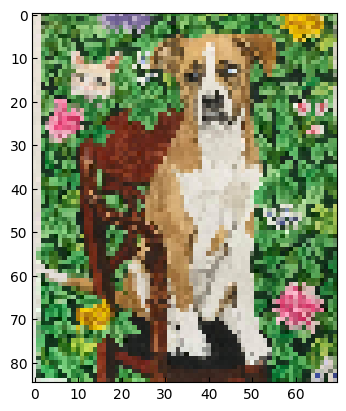

In [3]:
plt.imshow(image)


## Generating some data based on the image
### Define a non-linear function

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/generated.png?raw=true)

In [4]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [5]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3), length=10, function=non_linear_fn)


In [6]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


## Plots the generated data

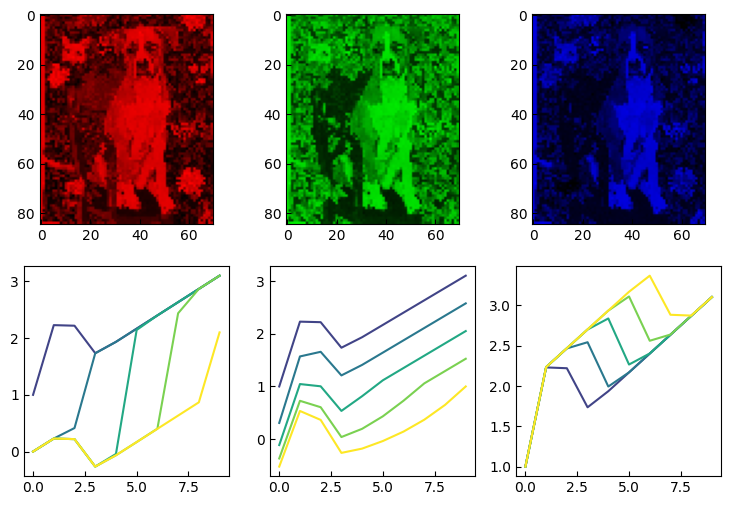

In [7]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


# Let's Build a Simple Autoencoder

## Defines the encoder and the decoder

In [8]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


## Builds the autoencoder

In [9]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


# Instantiates the model

In [10]:
import cpuinfo
cpudata = cpuinfo.get_cpu_info()['brand_raw']
cpuname = cpudata.split(" ")[1]

if cpuname == 'M1':
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else: 
    device = "cpu"

print(f'You are running on a {device}')

encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a cuda


In [11]:
try: 
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to('cpu')
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


* Encoder with 12 latent dimensions
* Decoder with with size 10 --> same as orignal spectral length
* Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample

In [12]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)


In [13]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.51it/s]

Epoch 0, Train Loss: 2.0258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.80it/s]

Epoch 1, Train Loss: 1.8672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.80it/s]

Epoch 2, Train Loss: 1.7234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.02it/s]

Epoch 3, Train Loss: 1.5876
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.26it/s]

Epoch 4, Train Loss: 1.4530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.63it/s]

Epoch 5, Train Loss: 1.3249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.03it/s]

Epoch 6, Train Loss: 1.1978
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.73it/s]

Epoch 7, Train Loss: 1.0733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.59it/s]

Epoch 8, Train Loss: 0.9534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.64it/s]

Epoch 9, Train Loss: 0.8414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.81it/s]

Epoch 10, Train Loss: 0.7352
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.31it/s]

Epoch 11, Train Loss: 0.6400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.99it/s]

Epoch 12, Train Loss: 0.5550
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 827.08it/s]

Epoch 13, Train Loss: 0.4808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.94it/s]

Epoch 14, Train Loss: 0.4169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.71it/s]

Epoch 15, Train Loss: 0.3645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.60it/s]

Epoch 16, Train Loss: 0.3201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.51it/s]

Epoch 17, Train Loss: 0.2844
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 580.29it/s]

Epoch 18, Train Loss: 0.2561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.62it/s]

Epoch 19, Train Loss: 0.2339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.82it/s]

Epoch 20, Train Loss: 0.2164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.80it/s]

Epoch 21, Train Loss: 0.2023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.25it/s]

Epoch 22, Train Loss: 0.1910
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.72it/s]

Epoch 23, Train Loss: 0.1826
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.05it/s]

Epoch 24, Train Loss: 0.1756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.43it/s]

Epoch 25, Train Loss: 0.1699
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.10it/s]

Epoch 26, Train Loss: 0.1653
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.57it/s]

Epoch 27, Train Loss: 0.1614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 28, Train Loss: 0.1577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.93it/s]

Epoch 29, Train Loss: 0.1545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.16it/s]

Epoch 30, Train Loss: 0.1517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 889.55it/s]

Epoch 31, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 840.96it/s]

Epoch 32, Train Loss: 0.1462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.27it/s]

Epoch 33, Train Loss: 0.1436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.96it/s]

Epoch 34, Train Loss: 0.1413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.95it/s]

Epoch 35, Train Loss: 0.1389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 870.90it/s]

Epoch 36, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.07it/s]

Epoch 37, Train Loss: 0.1342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.68it/s]

Epoch 38, Train Loss: 0.1318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.73it/s]

Epoch 39, Train Loss: 0.1296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.07it/s]

Epoch 40, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.72it/s]

Epoch 41, Train Loss: 0.1252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.97it/s]

Epoch 42, Train Loss: 0.1231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.16it/s]

Epoch 43, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.51it/s]

Epoch 44, Train Loss: 0.1188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.47it/s]

Epoch 45, Train Loss: 0.1166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.95it/s]

Epoch 46, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.96it/s]

Epoch 47, Train Loss: 0.1125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.96it/s]

Epoch 48, Train Loss: 0.1102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.97it/s]

Epoch 49, Train Loss: 0.1083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 50, Train Loss: 0.1063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.97it/s]

Epoch 51, Train Loss: 0.1041
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 903.12it/s]

Epoch 52, Train Loss: 0.1021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.31it/s]

Epoch 53, Train Loss: 0.1002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.45it/s]

Epoch 54, Train Loss: 0.0982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.88it/s]

Epoch 55, Train Loss: 0.0962
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.37it/s]

Epoch 56, Train Loss: 0.0944
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.28it/s]

Epoch 57, Train Loss: 0.0924
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 865.71it/s]

Epoch 58, Train Loss: 0.0905
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 800.10it/s]

Epoch 59, Train Loss: 0.0886
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.21it/s]

Epoch 60, Train Loss: 0.0867
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.31it/s]

Epoch 61, Train Loss: 0.0851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.09it/s]

Epoch 62, Train Loss: 0.0832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.24it/s]

Epoch 63, Train Loss: 0.0814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 827.53it/s]

Epoch 64, Train Loss: 0.0800
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.47it/s]

Epoch 65, Train Loss: 0.0782
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.28it/s]

Epoch 66, Train Loss: 0.0764
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 592.69it/s]

Epoch 67, Train Loss: 0.0750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.15it/s]

Epoch 68, Train Loss: 0.0733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.94it/s]

Epoch 69, Train Loss: 0.0720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.96it/s]

Epoch 70, Train Loss: 0.0705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.91it/s]

Epoch 71, Train Loss: 0.0690
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.13it/s]

Epoch 72, Train Loss: 0.0677
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.40it/s]

Epoch 73, Train Loss: 0.0663
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.76it/s]

Epoch 74, Train Loss: 0.0650
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.30it/s]

Epoch 75, Train Loss: 0.0637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.99it/s]

Epoch 76, Train Loss: 0.0624
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.34it/s]

Epoch 77, Train Loss: 0.0612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.34it/s]

Epoch 78, Train Loss: 0.0600
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.04it/s]

Epoch 79, Train Loss: 0.0589
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.01it/s]

Epoch 80, Train Loss: 0.0577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.51it/s]

Epoch 81, Train Loss: 0.0567
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.86it/s]

Epoch 82, Train Loss: 0.0556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.96it/s]

Epoch 83, Train Loss: 0.0548
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.73it/s]

Epoch 84, Train Loss: 0.0538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.73it/s]

Epoch 85, Train Loss: 0.0528
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.72it/s]

Epoch 86, Train Loss: 0.0519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.12it/s]

Epoch 87, Train Loss: 0.0511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.81it/s]

Epoch 88, Train Loss: 0.0501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.06it/s]

Epoch 89, Train Loss: 0.0493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.79it/s]

Epoch 90, Train Loss: 0.0485
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.52it/s]

Epoch 91, Train Loss: 0.0476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.41it/s]

Epoch 92, Train Loss: 0.0469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.76it/s]

Epoch 93, Train Loss: 0.0462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.84it/s]

Epoch 94, Train Loss: 0.0453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.00it/s]

Epoch 95, Train Loss: 0.0446
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.63it/s]

Epoch 96, Train Loss: 0.0440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.81it/s]

Epoch 97, Train Loss: 0.0432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.25it/s]

Epoch 98, Train Loss: 0.0426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.30it/s]

Epoch 99, Train Loss: 0.0420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.37it/s]

Epoch 100, Train Loss: 0.0413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.93it/s]

Epoch 101, Train Loss: 0.0407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.63it/s]

Epoch 102, Train Loss: 0.0401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.91it/s]

Epoch 103, Train Loss: 0.0396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 475.12it/s]

Epoch 104, Train Loss: 0.0390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.79it/s]

Epoch 105, Train Loss: 0.0384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.76it/s]

Epoch 106, Train Loss: 0.0379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.83it/s]

Epoch 107, Train Loss: 0.0374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.90it/s]

Epoch 108, Train Loss: 0.0368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.40it/s]

Epoch 109, Train Loss: 0.0363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.97it/s]

Epoch 110, Train Loss: 0.0359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.04it/s]

Epoch 111, Train Loss: 0.0353
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 112, Train Loss: 0.0349
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.79it/s]

Epoch 113, Train Loss: 0.0344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.09it/s]

Epoch 114, Train Loss: 0.0340
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 857.54it/s]

Epoch 115, Train Loss: 0.0335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 908.59it/s]

Epoch 116, Train Loss: 0.0330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 827.35it/s]

Epoch 117, Train Loss: 0.0326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.86it/s]

Epoch 118, Train Loss: 0.0322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.70it/s]

Epoch 119, Train Loss: 0.0318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 766.87it/s]

Epoch 120, Train Loss: 0.0314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.10it/s]

Epoch 121, Train Loss: 0.0310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.95it/s]

Epoch 122, Train Loss: 0.0306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 123, Train Loss: 0.0303
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.01it/s]

Epoch 124, Train Loss: 0.0298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.98it/s]

Epoch 125, Train Loss: 0.0296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.92it/s]

Epoch 126, Train Loss: 0.0291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.66it/s]

Epoch 127, Train Loss: 0.0288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.59it/s]

Epoch 128, Train Loss: 0.0284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.78it/s]

Epoch 129, Train Loss: 0.0281
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.10it/s]

Epoch 130, Train Loss: 0.0278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.61it/s]

Epoch 131, Train Loss: 0.0275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.83it/s]

Epoch 132, Train Loss: 0.0271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.06it/s]

Epoch 133, Train Loss: 0.0268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.06it/s]

Epoch 134, Train Loss: 0.0265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.11it/s]

Epoch 135, Train Loss: 0.0262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 827.06it/s]

Epoch 136, Train Loss: 0.0259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.16it/s]

Epoch 137, Train Loss: 0.0256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.36it/s]

Epoch 138, Train Loss: 0.0253
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.34it/s]

Epoch 139, Train Loss: 0.0250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.06it/s]

Epoch 140, Train Loss: 0.0247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.33it/s]

Epoch 141, Train Loss: 0.0245
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.07it/s]

Epoch 142, Train Loss: 0.0241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.78it/s]

Epoch 143, Train Loss: 0.0239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.56it/s]

Epoch 144, Train Loss: 0.0236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.95it/s]

Epoch 145, Train Loss: 0.0234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.84it/s]

Epoch 146, Train Loss: 0.0231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.98it/s]

Epoch 147, Train Loss: 0.0228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.88it/s]

Epoch 148, Train Loss: 0.0226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.87it/s]

Epoch 149, Train Loss: 0.0223
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.90it/s]

Epoch 150, Train Loss: 0.0221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.43it/s]

Epoch 151, Train Loss: 0.0218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.46it/s]

Epoch 152, Train Loss: 0.0215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.48it/s]

Epoch 153, Train Loss: 0.0213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.68it/s]

Epoch 154, Train Loss: 0.0210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.87it/s]

Epoch 155, Train Loss: 0.0208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.54it/s]

Epoch 156, Train Loss: 0.0206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.44it/s]

Epoch 157, Train Loss: 0.0203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.88it/s]

Epoch 158, Train Loss: 0.0201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 841.49it/s]

Epoch 159, Train Loss: 0.0199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.15it/s]

Epoch 160, Train Loss: 0.0196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.01it/s]

Epoch 161, Train Loss: 0.0194
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.06it/s]

Epoch 162, Train Loss: 0.0192
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.03it/s]

Epoch 163, Train Loss: 0.0190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.14it/s]

Epoch 164, Train Loss: 0.0187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.93it/s]

Epoch 165, Train Loss: 0.0185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.65it/s]

Epoch 166, Train Loss: 0.0183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.54it/s]

Epoch 167, Train Loss: 0.0181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.15it/s]

Epoch 168, Train Loss: 0.0179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.78it/s]

Epoch 169, Train Loss: 0.0177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.71it/s]

Epoch 170, Train Loss: 0.0174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.00it/s]

Epoch 171, Train Loss: 0.0172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.41it/s]

Epoch 172, Train Loss: 0.0170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.77it/s]

Epoch 173, Train Loss: 0.0168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.14it/s]

Epoch 174, Train Loss: 0.0166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.46it/s]

Epoch 175, Train Loss: 0.0164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.76it/s]

Epoch 176, Train Loss: 0.0162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.56it/s]

Epoch 177, Train Loss: 0.0160
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 861.79it/s]

Epoch 178, Train Loss: 0.0158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.97it/s]

Epoch 179, Train Loss: 0.0156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.35it/s]

Epoch 180, Train Loss: 0.0153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.04it/s]

Epoch 181, Train Loss: 0.0152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.15it/s]

Epoch 182, Train Loss: 0.0150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 878.10it/s]

Epoch 183, Train Loss: 0.0148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.80it/s]

Epoch 184, Train Loss: 0.0146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.82it/s]

Epoch 185, Train Loss: 0.0144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.54it/s]

Epoch 186, Train Loss: 0.0142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.55it/s]

Epoch 187, Train Loss: 0.0140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.16it/s]

Epoch 188, Train Loss: 0.0138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.62it/s]

Epoch 189, Train Loss: 0.0136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.36it/s]

Epoch 190, Train Loss: 0.0134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.69it/s]

Epoch 191, Train Loss: 0.0132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.96it/s]

Epoch 192, Train Loss: 0.0131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.61it/s]

Epoch 193, Train Loss: 0.0128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 194, Train Loss: 0.0126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.06it/s]

Epoch 195, Train Loss: 0.0125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.77it/s]

Epoch 196, Train Loss: 0.0124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.25it/s]

Epoch 197, Train Loss: 0.0122
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.02it/s]

Epoch 198, Train Loss: 0.0119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.02it/s]

Epoch 199, Train Loss: 0.0118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 832.37it/s]

Epoch 200, Train Loss: 0.0116
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.91it/s]

Epoch 201, Train Loss: 0.0114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.80it/s]

Epoch 202, Train Loss: 0.0113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.66it/s]

Epoch 203, Train Loss: 0.0111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.72it/s]

Epoch 204, Train Loss: 0.0109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.65it/s]

Epoch 205, Train Loss: 0.0108
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 206, Train Loss: 0.0106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.97it/s]

Epoch 207, Train Loss: 0.0104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.18it/s]

Epoch 208, Train Loss: 0.0102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.83it/s]

Epoch 209, Train Loss: 0.0101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.08it/s]

Epoch 210, Train Loss: 0.0099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.62it/s]

Epoch 211, Train Loss: 0.0098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.88it/s]

Epoch 212, Train Loss: 0.0096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.39it/s]

Epoch 213, Train Loss: 0.0095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.19it/s]

Epoch 214, Train Loss: 0.0093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.49it/s]

Epoch 215, Train Loss: 0.0092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 216, Train Loss: 0.0090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.67it/s]

Epoch 217, Train Loss: 0.0088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.04it/s]

Epoch 218, Train Loss: 0.0087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.76it/s]

Epoch 219, Train Loss: 0.0086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.06it/s]

Epoch 220, Train Loss: 0.0084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 852.02it/s]

Epoch 221, Train Loss: 0.0083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.09it/s]

Epoch 222, Train Loss: 0.0081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.00it/s]

Epoch 223, Train Loss: 0.0080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.12it/s]

Epoch 224, Train Loss: 0.0078
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.45it/s]

Epoch 225, Train Loss: 0.0077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.67it/s]

Epoch 226, Train Loss: 0.0076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.17it/s]

Epoch 227, Train Loss: 0.0075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.74it/s]

Epoch 228, Train Loss: 0.0073
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 812.24it/s]

Epoch 229, Train Loss: 0.0072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.46it/s]

Epoch 230, Train Loss: 0.0071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.05it/s]

Epoch 231, Train Loss: 0.0070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.50it/s]

Epoch 232, Train Loss: 0.0068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.92it/s]

Epoch 233, Train Loss: 0.0067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.81it/s]

Epoch 234, Train Loss: 0.0066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 404.57it/s]

Epoch 235, Train Loss: 0.0065
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.61it/s]

Epoch 236, Train Loss: 0.0064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.72it/s]

Epoch 237, Train Loss: 0.0063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.63it/s]

Epoch 238, Train Loss: 0.0062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.17it/s]

Epoch 239, Train Loss: 0.0061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.77it/s]

Epoch 240, Train Loss: 0.0060
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 652.64it/s]

Epoch 241, Train Loss: 0.0059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.80it/s]

Epoch 242, Train Loss: 0.0058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.72it/s]

Epoch 243, Train Loss: 0.0057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.81it/s]

Epoch 244, Train Loss: 0.0057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.71it/s]

Epoch 245, Train Loss: 0.0056
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 633.25it/s]

Epoch 246, Train Loss: 0.0055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 651.94it/s]

Epoch 247, Train Loss: 0.0054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 706.82it/s]

Epoch 248, Train Loss: 0.0054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.56it/s]

Epoch 249, Train Loss: 0.0053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.19it/s]

Epoch 250, Train Loss: 0.0052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 787.20it/s]

Epoch 251, Train Loss: 0.0051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 794.99it/s]

Epoch 252, Train Loss: 0.0051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 763.39it/s]

Epoch 253, Train Loss: 0.0050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.41it/s]

Epoch 254, Train Loss: 0.0049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 771.48it/s]

Epoch 255, Train Loss: 0.0049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.73it/s]

Epoch 256, Train Loss: 0.0048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.16it/s]

Epoch 257, Train Loss: 0.0048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.39it/s]

Epoch 258, Train Loss: 0.0047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.46it/s]

Epoch 259, Train Loss: 0.0047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.07it/s]

Epoch 260, Train Loss: 0.0046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.73it/s]

Epoch 261, Train Loss: 0.0046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.62it/s]

Epoch 262, Train Loss: 0.0045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.42it/s]

Epoch 263, Train Loss: 0.0045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.83it/s]

Epoch 264, Train Loss: 0.0045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.62it/s]

Epoch 265, Train Loss: 0.0044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.02it/s]

Epoch 266, Train Loss: 0.0044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.44it/s]

Epoch 267, Train Loss: 0.0044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.68it/s]

Epoch 268, Train Loss: 0.0043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.43it/s]

Epoch 269, Train Loss: 0.0043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.48it/s]

Epoch 270, Train Loss: 0.0043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.35it/s]

Epoch 271, Train Loss: 0.0042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.13it/s]

Epoch 272, Train Loss: 0.0042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.30it/s]

Epoch 273, Train Loss: 0.0042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.36it/s]

Epoch 274, Train Loss: 0.0042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.51it/s]

Epoch 275, Train Loss: 0.0041
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.59it/s]

Epoch 276, Train Loss: 0.0041
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.87it/s]

Epoch 277, Train Loss: 0.0041
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.95it/s]

Epoch 278, Train Loss: 0.0041
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.57it/s]

Epoch 279, Train Loss: 0.0040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 487.74it/s]

Epoch 280, Train Loss: 0.0040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 432.10it/s]

Epoch 281, Train Loss: 0.0040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.64it/s]

Epoch 282, Train Loss: 0.0040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.71it/s]

Epoch 283, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.62it/s]

Epoch 284, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.47it/s]

Epoch 285, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.04it/s]

Epoch 286, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.97it/s]

Epoch 287, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 654.02it/s]

Epoch 288, Train Loss: 0.0039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 655.33it/s]

Epoch 289, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 652.46it/s]

Epoch 290, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 681.81it/s]

Epoch 291, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 655.92it/s]

Epoch 292, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 652.57it/s]

Epoch 293, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.54it/s]

Epoch 294, Train Loss: 0.0038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.56it/s]

Epoch 295, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.85it/s]

Epoch 296, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 528.15it/s]

Epoch 297, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.60it/s]

Epoch 298, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.81it/s]

Epoch 299, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.96it/s]

Epoch 300, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.86it/s]

Epoch 301, Train Loss: 0.0037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.74it/s]

Epoch 302, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.58it/s]

Epoch 303, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.74it/s]

Epoch 304, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.13it/s]

Epoch 305, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.85it/s]

Epoch 306, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.92it/s]

Epoch 307, Train Loss: 0.0036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.91it/s]

Epoch 308, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.64it/s]

Epoch 309, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 654.71it/s]

Epoch 310, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 652.72it/s]

Epoch 311, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 744.91it/s]

Epoch 312, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.01it/s]

Epoch 313, Train Loss: 0.0035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.96it/s]

Epoch 314, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.89it/s]

Epoch 315, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.51it/s]

Epoch 316, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.79it/s]

Epoch 317, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.72it/s]

Epoch 318, Train Loss: 0.0034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.90it/s]

Epoch 319, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.81it/s]

Epoch 320, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.88it/s]

Epoch 321, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.06it/s]

Epoch 322, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 866.01it/s]

Epoch 323, Train Loss: 0.0033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.35it/s]

Epoch 324, Train Loss: 0.0032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.89it/s]

Epoch 325, Train Loss: 0.0032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 823.65it/s]

Epoch 326, Train Loss: 0.0032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.07it/s]

Epoch 327, Train Loss: 0.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.71it/s]

Epoch 328, Train Loss: 0.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.38it/s]

Epoch 329, Train Loss: 0.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.96it/s]

Epoch 330, Train Loss: 0.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.83it/s]

Epoch 331, Train Loss: 0.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.22it/s]

Epoch 332, Train Loss: 0.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.16it/s]

Epoch 333, Train Loss: 0.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.81it/s]

Epoch 334, Train Loss: 0.0030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 654.48it/s]

Epoch 335, Train Loss: 0.0029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.23it/s]

Epoch 336, Train Loss: 0.0029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.49it/s]

Epoch 337, Train Loss: 0.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.91it/s]

Epoch 338, Train Loss: 0.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.62it/s]

Epoch 339, Train Loss: 0.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.86it/s]

Epoch 340, Train Loss: 0.0027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 422.85it/s]

Epoch 341, Train Loss: 0.0027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 559.09it/s]

Epoch 342, Train Loss: 0.0027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.10it/s]

Epoch 343, Train Loss: 0.0027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.93it/s]

Epoch 344, Train Loss: 0.0026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.10it/s]

Epoch 345, Train Loss: 0.0026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.61it/s]

Epoch 346, Train Loss: 0.0025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 748.99it/s]

Epoch 347, Train Loss: 0.0025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.85it/s]

Epoch 348, Train Loss: 0.0024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 799.60it/s]

Epoch 349, Train Loss: 0.0024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 753.66it/s]

Epoch 350, Train Loss: 0.0024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.12it/s]

Epoch 351, Train Loss: 0.0023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.34it/s]

Epoch 352, Train Loss: 0.0023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.73it/s]

Epoch 353, Train Loss: 0.0022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.63it/s]

Epoch 354, Train Loss: 0.0022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.80it/s]

Epoch 355, Train Loss: 0.0021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 903.98it/s]

Epoch 356, Train Loss: 0.0021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.67it/s]

Epoch 357, Train Loss: 0.0021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.44it/s]

Epoch 358, Train Loss: 0.0020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.54it/s]

Epoch 359, Train Loss: 0.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.58it/s]

Epoch 360, Train Loss: 0.0019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.44it/s]

Epoch 361, Train Loss: 0.0018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 413.04it/s]

Epoch 362, Train Loss: 0.0018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.50it/s]

Epoch 363, Train Loss: 0.0018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 613.02it/s]

Epoch 364, Train Loss: 0.0017
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.24it/s]

Epoch 365, Train Loss: 0.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.36it/s]

Epoch 366, Train Loss: 0.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.49it/s]

Epoch 367, Train Loss: 0.0015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 827.05it/s]

Epoch 368, Train Loss: 0.0015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 793.05it/s]

Epoch 369, Train Loss: 0.0014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.48it/s]

Epoch 370, Train Loss: 0.0014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.26it/s]

Epoch 371, Train Loss: 0.0013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.06it/s]

Epoch 372, Train Loss: 0.0013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.02it/s]

Epoch 373, Train Loss: 0.0012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.17it/s]

Epoch 374, Train Loss: 0.0012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.04it/s]

Epoch 375, Train Loss: 0.0011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.31it/s]

Epoch 376, Train Loss: 0.0011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.83it/s]

Epoch 377, Train Loss: 0.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.63it/s]

Epoch 378, Train Loss: 0.0010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.87it/s]

Epoch 379, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 380, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 720.79it/s]

Epoch 381, Train Loss: 0.0009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.16it/s]

Epoch 382, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.03it/s]

Epoch 383, Train Loss: 0.0008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.78it/s]

Epoch 384, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 613.95it/s]

Epoch 385, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.99it/s]

Epoch 386, Train Loss: 0.0007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 432.30it/s]

Epoch 387, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 513.69it/s]

Epoch 388, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.67it/s]

Epoch 389, Train Loss: 0.0006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.61it/s]

Epoch 390, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 391, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.69it/s]

Epoch 392, Train Loss: 0.0005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.10it/s]

Epoch 393, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.60it/s]

Epoch 394, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.05it/s]

Epoch 395, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.06it/s]

Epoch 396, Train Loss: 0.0004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.20it/s]

Epoch 397, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 699.77it/s]

Epoch 398, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 903.92it/s]

Epoch 399, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 400, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 793.36it/s]

Epoch 401, Train Loss: 0.0003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.96it/s]

Epoch 402, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.71it/s]

Epoch 403, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.78it/s]

Epoch 404, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.47it/s]

Epoch 405, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.24it/s]

Epoch 406, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.46it/s]

Epoch 407, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.77it/s]

Epoch 408, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.56it/s]

Epoch 409, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.62it/s]

Epoch 410, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.88it/s]

Epoch 411, Train Loss: 0.0002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 441.68it/s]

Epoch 412, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.60it/s]

Epoch 413, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.69it/s]

Epoch 414, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.37it/s]

Epoch 415, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 865.27it/s]

Epoch 416, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 417, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.31it/s]

Epoch 418, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.13it/s]

Epoch 419, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.79it/s]

Epoch 420, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.98it/s]

Epoch 421, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.43it/s]

Epoch 422, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.72it/s]

Epoch 423, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 903.10it/s]

Epoch 424, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 656.38it/s]

Epoch 425, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.71it/s]

Epoch 426, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.97it/s]

Epoch 427, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.84it/s]

Epoch 428, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.27it/s]

Epoch 429, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.40it/s]

Epoch 430, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 813.18it/s]

Epoch 431, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.91it/s]

Epoch 432, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.89it/s]

Epoch 433, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.81it/s]

Epoch 434, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.85it/s]

Epoch 435, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.58it/s]

Epoch 436, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.42it/s]

Epoch 437, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.98it/s]

Epoch 438, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.33it/s]

Epoch 439, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.79it/s]

Epoch 440, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.81it/s]

Epoch 441, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.00it/s]

Epoch 442, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.59it/s]

Epoch 443, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 793.44it/s]

Epoch 444, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 682.46it/s]

Epoch 445, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.16it/s]

Epoch 446, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.61it/s]

Epoch 447, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.78it/s]

Epoch 448, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.07it/s]

Epoch 449, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.61it/s]

Epoch 450, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.14it/s]

Epoch 451, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.00it/s]

Epoch 452, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.47it/s]

Epoch 453, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 902.66it/s]

Epoch 454, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.31it/s]

Epoch 455, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.84it/s]

Epoch 456, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.50it/s]

Epoch 457, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.93it/s]

Epoch 458, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.92it/s]

Epoch 459, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.73it/s]

Epoch 460, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.49it/s]

Epoch 461, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 902.81it/s]

Epoch 462, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.86it/s]

Epoch 463, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.68it/s]

Epoch 464, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.40it/s]

Epoch 465, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.74it/s]

Epoch 466, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 634.78it/s]

Epoch 467, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.59it/s]

Epoch 468, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.56it/s]

Epoch 469, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.53it/s]

Epoch 470, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 733.78it/s]

Epoch 471, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.76it/s]

Epoch 472, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.40it/s]

Epoch 473, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.89it/s]

Epoch 474, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.64it/s]

Epoch 475, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.19it/s]

Epoch 476, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.27it/s]

Epoch 477, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.47it/s]

Epoch 478, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.92it/s]

Epoch 479, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.65it/s]

Epoch 480, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.91it/s]

Epoch 481, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.74it/s]

Epoch 482, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 815.38it/s]

Epoch 483, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.98it/s]

Epoch 484, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.81it/s]

Epoch 485, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.19it/s]

Epoch 486, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.96it/s]

Epoch 487, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.04it/s]

Epoch 488, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.75it/s]

Epoch 489, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.02it/s]

Epoch 490, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.16it/s]

Epoch 491, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.47it/s]

Epoch 492, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.99it/s]

Epoch 493, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.16it/s]

Epoch 494, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.67it/s]

Epoch 495, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.90it/s]

Epoch 496, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.30it/s]

Epoch 497, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.76it/s]

Epoch 498, Train Loss: 0.0001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.50it/s]

Epoch 499, Train Loss: 0.0001
.............................


In [14]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


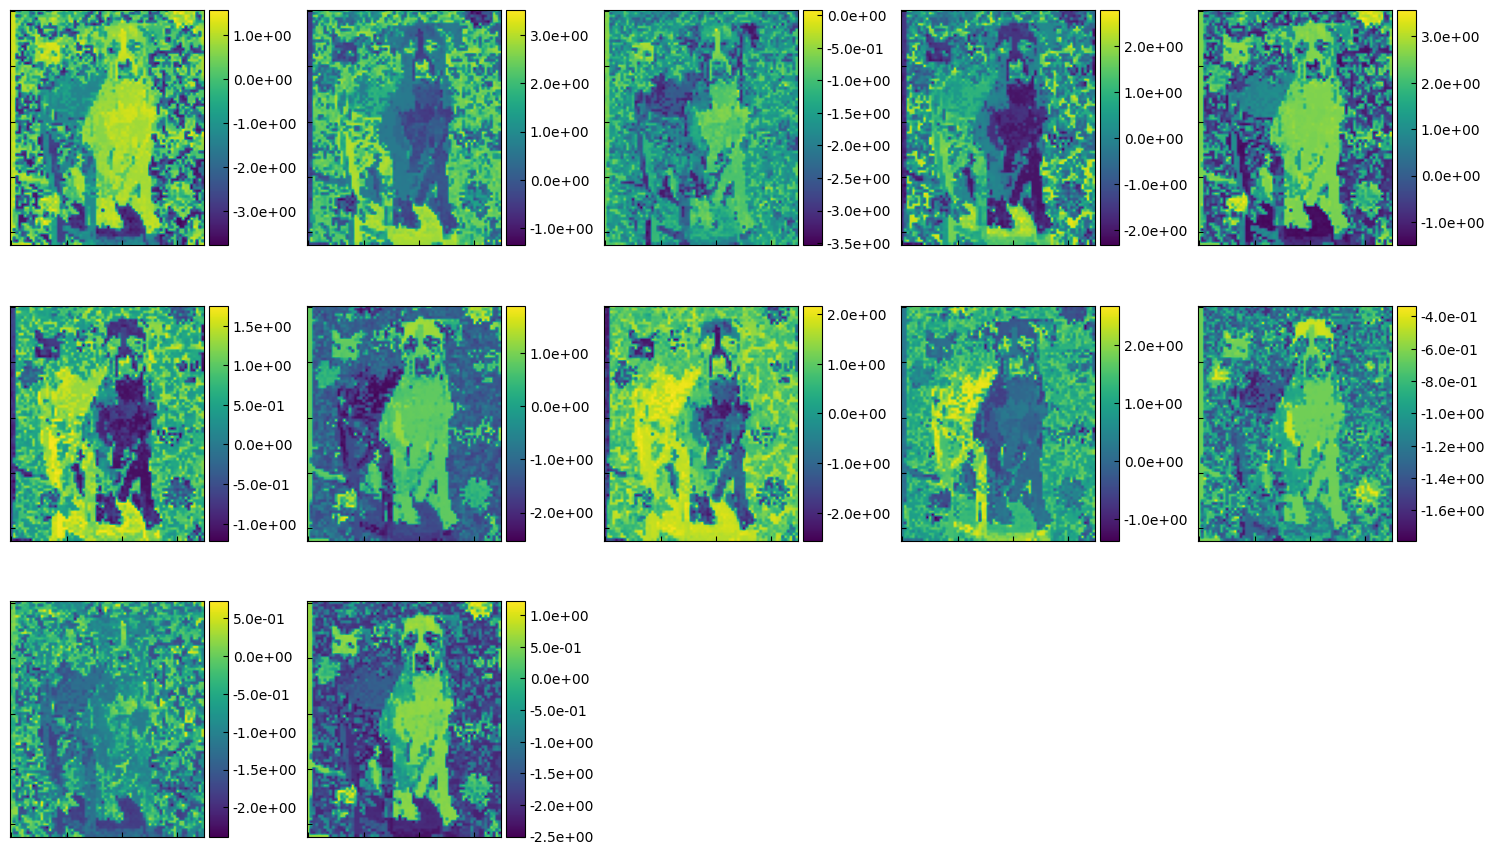

In [15]:
embedding_maps(encode, image)


* This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables

## We know that we only have 3 intrinsic latent variables

# Instantiates the model

In [16]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [17]:
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


* Encoder with 3 latent dimensions
* Decoder with with size 10 --> same as orignal spectral length
* Autoencoder considers time by saying each timestep is its own fully-uncorrelated sample

In [18]:
train_iterator = torch.utils.data.DataLoader(X_train, batch_size=256, shuffle=True)


In [19]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.72it/s]

Epoch 0, Train Loss: 2.3367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.98it/s]

Epoch 1, Train Loss: 2.2750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 2, Train Loss: 2.2174
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.71it/s]

Epoch 3, Train Loss: 2.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.66it/s]

Epoch 4, Train Loss: 2.1008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.56it/s]

Epoch 5, Train Loss: 2.0443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.31it/s]

Epoch 6, Train Loss: 1.9859
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.93it/s]

Epoch 7, Train Loss: 1.9263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.86it/s]

Epoch 8, Train Loss: 1.8688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.89it/s]

Epoch 9, Train Loss: 1.8143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.39it/s]

Epoch 10, Train Loss: 1.7565
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.92it/s]

Epoch 11, Train Loss: 1.7003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 559.19it/s]

Epoch 12, Train Loss: 1.6473
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.04it/s]

Epoch 13, Train Loss: 1.5919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.80it/s]

Epoch 14, Train Loss: 1.5402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.93it/s]

Epoch 15, Train Loss: 1.4904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.75it/s]

Epoch 16, Train Loss: 1.4413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 542.86it/s]

Epoch 17, Train Loss: 1.3927
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.69it/s]

Epoch 18, Train Loss: 1.3465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.55it/s]

Epoch 19, Train Loss: 1.3021
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.98it/s]

Epoch 20, Train Loss: 1.2592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.68it/s]

Epoch 21, Train Loss: 1.2171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.80it/s]

Epoch 22, Train Loss: 1.1775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.73it/s]

Epoch 23, Train Loss: 1.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.85it/s]

Epoch 24, Train Loss: 1.1007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.69it/s]

Epoch 25, Train Loss: 1.0630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.68it/s]

Epoch 26, Train Loss: 1.0293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 694.23it/s]

Epoch 27, Train Loss: 0.9960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 514.30it/s]

Epoch 28, Train Loss: 0.9644
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 655.45it/s]

Epoch 29, Train Loss: 0.9337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 630.41it/s]

Epoch 30, Train Loss: 0.9040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.85it/s]

Epoch 31, Train Loss: 0.8737
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.22it/s]

Epoch 32, Train Loss: 0.8487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.85it/s]

Epoch 33, Train Loss: 0.8216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 687.73it/s]

Epoch 34, Train Loss: 0.7967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 690.13it/s]

Epoch 35, Train Loss: 0.7724
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.06it/s]

Epoch 36, Train Loss: 0.7495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.16it/s]

Epoch 37, Train Loss: 0.7253
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.09it/s]

Epoch 38, Train Loss: 0.7036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.60it/s]

Epoch 39, Train Loss: 0.6820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.68it/s]

Epoch 40, Train Loss: 0.6621
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 902.88it/s]

Epoch 41, Train Loss: 0.6420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.98it/s]

Epoch 42, Train Loss: 0.6226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.69it/s]

Epoch 43, Train Loss: 0.6028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.71it/s]

Epoch 44, Train Loss: 0.5845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.80it/s]

Epoch 45, Train Loss: 0.5671
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 793.08it/s]

Epoch 46, Train Loss: 0.5484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.64it/s]

Epoch 47, Train Loss: 0.5322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.37it/s]

Epoch 48, Train Loss: 0.5142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.21it/s]

Epoch 49, Train Loss: 0.4982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.68it/s]

Epoch 50, Train Loss: 0.4824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.76it/s]

Epoch 51, Train Loss: 0.4666
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.32it/s]

Epoch 52, Train Loss: 0.4520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.19it/s]

Epoch 53, Train Loss: 0.4370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.98it/s]

Epoch 54, Train Loss: 0.4222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.56it/s]

Epoch 55, Train Loss: 0.4089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.26it/s]

Epoch 56, Train Loss: 0.3963
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.97it/s]

Epoch 57, Train Loss: 0.3831
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 805.14it/s]

Epoch 58, Train Loss: 0.3707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 774.36it/s]

Epoch 59, Train Loss: 0.3587
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.03it/s]

Epoch 60, Train Loss: 0.3478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.06it/s]

Epoch 61, Train Loss: 0.3368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.29it/s]

Epoch 62, Train Loss: 0.3263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.19it/s]

Epoch 63, Train Loss: 0.3157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.04it/s]

Epoch 64, Train Loss: 0.3075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.58it/s]

Epoch 65, Train Loss: 0.2977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.83it/s]

Epoch 66, Train Loss: 0.2886
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.92it/s]

Epoch 67, Train Loss: 0.2808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.84it/s]

Epoch 68, Train Loss: 0.2729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.52it/s]

Epoch 69, Train Loss: 0.2657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.35it/s]

Epoch 70, Train Loss: 0.2581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.65it/s]

Epoch 71, Train Loss: 0.2517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.76it/s]

Epoch 72, Train Loss: 0.2452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 903.07it/s]

Epoch 73, Train Loss: 0.2392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.65it/s]

Epoch 74, Train Loss: 0.2336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.69it/s]

Epoch 75, Train Loss: 0.2277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.05it/s]

Epoch 76, Train Loss: 0.2229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.48it/s]

Epoch 77, Train Loss: 0.2180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.88it/s]

Epoch 78, Train Loss: 0.2137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.70it/s]

Epoch 79, Train Loss: 0.2092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.65it/s]

Epoch 80, Train Loss: 0.2051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.99it/s]

Epoch 81, Train Loss: 0.2015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.07it/s]

Epoch 82, Train Loss: 0.1979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.61it/s]

Epoch 83, Train Loss: 0.1948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.42it/s]

Epoch 84, Train Loss: 0.1919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.02it/s]

Epoch 85, Train Loss: 0.1892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.03it/s]

Epoch 86, Train Loss: 0.1866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.19it/s]

Epoch 87, Train Loss: 0.1843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.77it/s]

Epoch 88, Train Loss: 0.1818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 749.91it/s]

Epoch 89, Train Loss: 0.1795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.25it/s]

Epoch 90, Train Loss: 0.1774
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.98it/s]

Epoch 91, Train Loss: 0.1757
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.93it/s]

Epoch 92, Train Loss: 0.1740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.53it/s]

Epoch 93, Train Loss: 0.1726
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.87it/s]

Epoch 94, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.02it/s]

Epoch 95, Train Loss: 0.1693
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.50it/s]

Epoch 96, Train Loss: 0.1684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.33it/s]

Epoch 97, Train Loss: 0.1670
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 698.51it/s]

Epoch 98, Train Loss: 0.1659
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.33it/s]

Epoch 99, Train Loss: 0.1652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 100, Train Loss: 0.1637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.67it/s]

Epoch 101, Train Loss: 0.1628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.11it/s]

Epoch 102, Train Loss: 0.1620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.95it/s]

Epoch 103, Train Loss: 0.1611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 903.45it/s]

Epoch 104, Train Loss: 0.1605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.33it/s]

Epoch 105, Train Loss: 0.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.68it/s]

Epoch 106, Train Loss: 0.1586
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.37it/s]

Epoch 107, Train Loss: 0.1584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.27it/s]

Epoch 108, Train Loss: 0.1574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.29it/s]

Epoch 109, Train Loss: 0.1568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.85it/s]

Epoch 110, Train Loss: 0.1564
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.42it/s]

Epoch 111, Train Loss: 0.1558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.65it/s]

Epoch 112, Train Loss: 0.1553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.05it/s]

Epoch 113, Train Loss: 0.1545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.36it/s]

Epoch 114, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.39it/s]

Epoch 115, Train Loss: 0.1534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.83it/s]

Epoch 116, Train Loss: 0.1528
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.40it/s]

Epoch 117, Train Loss: 0.1524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.74it/s]

Epoch 118, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.70it/s]

Epoch 119, Train Loss: 0.1517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.80it/s]

Epoch 120, Train Loss: 0.1513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.35it/s]

Epoch 121, Train Loss: 0.1507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.58it/s]

Epoch 122, Train Loss: 0.1503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.90it/s]

Epoch 123, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.93it/s]

Epoch 124, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.85it/s]

Epoch 125, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.74it/s]

Epoch 126, Train Loss: 0.1488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.60it/s]

Epoch 127, Train Loss: 0.1484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.07it/s]

Epoch 128, Train Loss: 0.1479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.55it/s]

Epoch 129, Train Loss: 0.1476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.53it/s]

Epoch 130, Train Loss: 0.1474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.84it/s]

Epoch 131, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.80it/s]

Epoch 132, Train Loss: 0.1463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.01it/s]

Epoch 133, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.19it/s]

Epoch 134, Train Loss: 0.1456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.71it/s]

Epoch 135, Train Loss: 0.1454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.94it/s]

Epoch 136, Train Loss: 0.1449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.79it/s]

Epoch 137, Train Loss: 0.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 601.49it/s]

Epoch 138, Train Loss: 0.1444
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.88it/s]

Epoch 139, Train Loss: 0.1443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.03it/s]

Epoch 140, Train Loss: 0.1436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.69it/s]

Epoch 141, Train Loss: 0.1436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.06it/s]

Epoch 142, Train Loss: 0.1429
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 905.14it/s]

Epoch 143, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.79it/s]

Epoch 144, Train Loss: 0.1422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 463.88it/s]

Epoch 145, Train Loss: 0.1421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 487.34it/s]

Epoch 146, Train Loss: 0.1415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.96it/s]

Epoch 147, Train Loss: 0.1413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.00it/s]

Epoch 148, Train Loss: 0.1410
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.08it/s]

Epoch 149, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.03it/s]

Epoch 150, Train Loss: 0.1403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.31it/s]

Epoch 151, Train Loss: 0.1400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.83it/s]

Epoch 152, Train Loss: 0.1397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.56it/s]

Epoch 153, Train Loss: 0.1394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 656.00it/s]

Epoch 154, Train Loss: 0.1388
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 155, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 156, Train Loss: 0.1382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.82it/s]

Epoch 157, Train Loss: 0.1380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.86it/s]

Epoch 158, Train Loss: 0.1379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.59it/s]

Epoch 159, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.61it/s]

Epoch 160, Train Loss: 0.1370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.02it/s]

Epoch 161, Train Loss: 0.1369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.45it/s]

Epoch 162, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.58it/s]

Epoch 163, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.18it/s]

Epoch 164, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.80it/s]

Epoch 165, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.52it/s]

Epoch 166, Train Loss: 0.1351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.71it/s]

Epoch 167, Train Loss: 0.1348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.25it/s]

Epoch 168, Train Loss: 0.1346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.02it/s]

Epoch 169, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.28it/s]

Epoch 170, Train Loss: 0.1338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.25it/s]

Epoch 171, Train Loss: 0.1335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 613.11it/s]

Epoch 172, Train Loss: 0.1333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.06it/s]

Epoch 173, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.62it/s]

Epoch 174, Train Loss: 0.1325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.68it/s]

Epoch 175, Train Loss: 0.1323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.75it/s]

Epoch 176, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.43it/s]

Epoch 177, Train Loss: 0.1320
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.30it/s]

Epoch 178, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.42it/s]

Epoch 179, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.85it/s]

Epoch 180, Train Loss: 0.1306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.99it/s]

Epoch 181, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.11it/s]

Epoch 182, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.81it/s]

Epoch 183, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 527.78it/s]

Epoch 184, Train Loss: 0.1297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.72it/s]

Epoch 185, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 186, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 187, Train Loss: 0.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.71it/s]

Epoch 188, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 189, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 190, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 191, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 192, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 193, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.79it/s]

Epoch 194, Train Loss: 0.1267
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.72it/s]

Epoch 195, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.58it/s]

Epoch 196, Train Loss: 0.1265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.12it/s]

Epoch 197, Train Loss: 0.1264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.02it/s]

Epoch 198, Train Loss: 0.1258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 199, Train Loss: 0.1256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.77it/s]

Epoch 200, Train Loss: 0.1254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 201, Train Loss: 0.1252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 202, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.01it/s]

Epoch 203, Train Loss: 0.1247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 204, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 205, Train Loss: 0.1241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.66it/s]

Epoch 206, Train Loss: 0.1237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.72it/s]

Epoch 207, Train Loss: 0.1236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.64it/s]

Epoch 208, Train Loss: 0.1235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.66it/s]

Epoch 209, Train Loss: 0.1232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.02it/s]

Epoch 210, Train Loss: 0.1230
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.80it/s]

Epoch 211, Train Loss: 0.1232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 612.91it/s]

Epoch 212, Train Loss: 0.1228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 213, Train Loss: 0.1227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.80it/s]

Epoch 214, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 215, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.66it/s]

Epoch 216, Train Loss: 0.1217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 217, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.70it/s]

Epoch 218, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.75it/s]

Epoch 219, Train Loss: 0.1213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.66it/s]

Epoch 220, Train Loss: 0.1211
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.12it/s]

Epoch 221, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 463.41it/s]

Epoch 222, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 575.76it/s]

Epoch 223, Train Loss: 0.1205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.76it/s]

Epoch 224, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.59it/s]

Epoch 225, Train Loss: 0.1202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 226, Train Loss: 0.1200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.77it/s]

Epoch 227, Train Loss: 0.1197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 228, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 229, Train Loss: 0.1196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 230, Train Loss: 0.1193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 231, Train Loss: 0.1191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.01it/s]

Epoch 232, Train Loss: 0.1189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 233, Train Loss: 0.1188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 234, Train Loss: 0.1186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.76it/s]

Epoch 235, Train Loss: 0.1186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.95it/s]

Epoch 236, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.58it/s]

Epoch 237, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 238, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.57it/s]

Epoch 239, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.56it/s]

Epoch 240, Train Loss: 0.1176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 241, Train Loss: 0.1175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.01it/s]

Epoch 242, Train Loss: 0.1177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.57it/s]

Epoch 243, Train Loss: 0.1173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.71it/s]

Epoch 244, Train Loss: 0.1171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.84it/s]

Epoch 245, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.58it/s]

Epoch 246, Train Loss: 0.1165
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.57it/s]

Epoch 247, Train Loss: 0.1167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.77it/s]

Epoch 248, Train Loss: 0.1164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 249, Train Loss: 0.1166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.71it/s]

Epoch 250, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 251, Train Loss: 0.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 252, Train Loss: 0.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.70it/s]

Epoch 253, Train Loss: 0.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 738.74it/s]

Epoch 254, Train Loss: 0.1157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.09it/s]

Epoch 255, Train Loss: 0.1155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.03it/s]

Epoch 256, Train Loss: 0.1155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 257, Train Loss: 0.1153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.65it/s]

Epoch 258, Train Loss: 0.1151
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 633.33it/s]

Epoch 259, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.80it/s]

Epoch 260, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.65it/s]

Epoch 261, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.64it/s]

Epoch 262, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 263, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 264, Train Loss: 0.1144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.11it/s]

Epoch 265, Train Loss: 0.1143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 266, Train Loss: 0.1141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.12it/s]

Epoch 267, Train Loss: 0.1139
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.81it/s]

Epoch 268, Train Loss: 0.1139
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.81it/s]

Epoch 269, Train Loss: 0.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 270, Train Loss: 0.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 808.27it/s]

Epoch 271, Train Loss: 0.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 795.64it/s]

Epoch 272, Train Loss: 0.1132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 273, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 388.56it/s]

Epoch 274, Train Loss: 0.1131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 536.15it/s]

Epoch 275, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 620.15it/s]

Epoch 276, Train Loss: 0.1127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 755.99it/s]

Epoch 277, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 351.86it/s]

Epoch 278, Train Loss: 0.1125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 475.62it/s]

Epoch 279, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 388.00it/s]

Epoch 280, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 421.94it/s]

Epoch 281, Train Loss: 0.1123
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 634.09it/s]

Epoch 282, Train Loss: 0.1121
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 778.96it/s]

Epoch 283, Train Loss: 0.1118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.23it/s]

Epoch 284, Train Loss: 0.1118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.10it/s]

Epoch 285, Train Loss: 0.1117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.64it/s]

Epoch 286, Train Loss: 0.1119
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.24it/s]

Epoch 287, Train Loss: 0.1115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 864.60it/s]

Epoch 288, Train Loss: 0.1115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.46it/s]

Epoch 289, Train Loss: 0.1113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.71it/s]

Epoch 290, Train Loss: 0.1111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.93it/s]

Epoch 291, Train Loss: 0.1110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.93it/s]

Epoch 292, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.82it/s]

Epoch 293, Train Loss: 0.1110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.33it/s]

Epoch 294, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.68it/s]

Epoch 295, Train Loss: 0.1107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.50it/s]

Epoch 296, Train Loss: 0.1106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.48it/s]

Epoch 297, Train Loss: 0.1104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.86it/s]

Epoch 298, Train Loss: 0.1101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.89it/s]

Epoch 299, Train Loss: 0.1100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 731.38it/s]

Epoch 300, Train Loss: 0.1101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.37it/s]

Epoch 301, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 861.94it/s]

Epoch 302, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.33it/s]

Epoch 303, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.75it/s]

Epoch 304, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.88it/s]

Epoch 305, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.19it/s]

Epoch 306, Train Loss: 0.1093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.22it/s]

Epoch 307, Train Loss: 0.1090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.33it/s]

Epoch 308, Train Loss: 0.1091
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.51it/s]

Epoch 309, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.03it/s]

Epoch 310, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.16it/s]

Epoch 311, Train Loss: 0.1089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.61it/s]

Epoch 312, Train Loss: 0.1084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.98it/s]

Epoch 313, Train Loss: 0.1086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.85it/s]

Epoch 314, Train Loss: 0.1086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 417.14it/s]

Epoch 315, Train Loss: 0.1086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 406.74it/s]

Epoch 316, Train Loss: 0.1082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 431.93it/s]

Epoch 317, Train Loss: 0.1082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 432.08it/s]

Epoch 318, Train Loss: 0.1080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 463.53it/s]

Epoch 319, Train Loss: 0.1080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.78it/s]

Epoch 320, Train Loss: 0.1078
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 726.47it/s]

Epoch 321, Train Loss: 0.1076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 667.59it/s]

Epoch 322, Train Loss: 0.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 633.33it/s]

Epoch 323, Train Loss: 0.1077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 175.97it/s]

100%|██████████| 19/19 [00:00<00:00, 171.14it/s]

Epoch 324, Train Loss: 0.1075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 185.65it/s]

100%|██████████| 19/19 [00:00<00:00, 182.10it/s]

Epoch 325, Train Loss: 0.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 612.91it/s]

Epoch 326, Train Loss: 0.1073
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.84it/s]

Epoch 327, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 626.29it/s]

Epoch 328, Train Loss: 0.1072
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 161.82it/s]

100%|██████████| 19/19 [00:00<00:00, 151.92it/s]

Epoch 329, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.85it/s]

Epoch 330, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 403.95it/s]

Epoch 331, Train Loss: 0.1067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 835.12it/s]

Epoch 332, Train Loss: 0.1067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 824.98it/s]

Epoch 333, Train Loss: 0.1063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 334, Train Loss: 0.1062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.82it/s]

Epoch 335, Train Loss: 0.1064
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.13it/s]

Epoch 336, Train Loss: 0.1061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.92it/s]

Epoch 337, Train Loss: 0.1061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 903.46it/s]

Epoch 338, Train Loss: 0.1062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 487.67it/s]

Epoch 339, Train Loss: 0.1061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.72it/s]

Epoch 340, Train Loss: 0.1058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.26it/s]

Epoch 341, Train Loss: 0.1059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.36it/s]

Epoch 342, Train Loss: 0.1058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.41it/s]

Epoch 343, Train Loss: 0.1057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.03it/s]

Epoch 344, Train Loss: 0.1057
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.40it/s]

Epoch 345, Train Loss: 0.1053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.02it/s]

Epoch 346, Train Loss: 0.1054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.54it/s]

Epoch 347, Train Loss: 0.1053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.21it/s]

Epoch 348, Train Loss: 0.1051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 789.99it/s]

Epoch 349, Train Loss: 0.1051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.32it/s]

Epoch 350, Train Loss: 0.1050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.79it/s]

Epoch 351, Train Loss: 0.1048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 514.17it/s]

Epoch 352, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 559.44it/s]

Epoch 353, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.45it/s]

Epoch 354, Train Loss: 0.1044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.35it/s]

Epoch 355, Train Loss: 0.1045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 755.83it/s]

Epoch 356, Train Loss: 0.1044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 611.61it/s]

Epoch 357, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 188.26it/s]

100%|██████████| 19/19 [00:00<00:00, 182.88it/s]

Epoch 358, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 176.36it/s]

100%|██████████| 19/19 [00:00<00:00, 168.10it/s]

Epoch 359, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 339.54it/s]

Epoch 360, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.18it/s]

Epoch 361, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.66it/s]

Epoch 362, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.60it/s]

Epoch 363, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.24it/s]

Epoch 364, Train Loss: 0.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.08it/s]

Epoch 365, Train Loss: 0.1036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.24it/s]

Epoch 366, Train Loss: 0.1038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.63it/s]

Epoch 367, Train Loss: 0.1035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.29it/s]

Epoch 368, Train Loss: 0.1036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.76it/s]

Epoch 369, Train Loss: 0.1034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 718.70it/s]

Epoch 370, Train Loss: 0.1031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.93it/s]

Epoch 371, Train Loss: 0.1031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.07it/s]

Epoch 372, Train Loss: 0.1030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.77it/s]

Epoch 373, Train Loss: 0.1030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 374, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.87it/s]

Epoch 375, Train Loss: 0.1028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 767.93it/s]

Epoch 376, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.93it/s]

Epoch 377, Train Loss: 0.1024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 378, Train Loss: 0.1025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.76it/s]

Epoch 379, Train Loss: 0.1023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 825.58it/s]

Epoch 380, Train Loss: 0.1026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.84it/s]

Epoch 381, Train Loss: 0.1023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 382, Train Loss: 0.1022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.35it/s]

Epoch 383, Train Loss: 0.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 761.30it/s]

Epoch 384, Train Loss: 0.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.52it/s]

Epoch 385, Train Loss: 0.1020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.90it/s]

Epoch 386, Train Loss: 0.1019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.50it/s]

Epoch 387, Train Loss: 0.1018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 790.56it/s]

Epoch 388, Train Loss: 0.1018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 862.80it/s]

Epoch 389, Train Loss: 0.1018
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.76it/s]

Epoch 390, Train Loss: 0.1014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.97it/s]

Epoch 391, Train Loss: 0.1013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.69it/s]

Epoch 392, Train Loss: 0.1015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.61it/s]

Epoch 393, Train Loss: 0.1012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 793.10it/s]

Epoch 394, Train Loss: 0.1013
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.11it/s]

Epoch 395, Train Loss: 0.1011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.27it/s]

Epoch 396, Train Loss: 0.1009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.66it/s]

Epoch 397, Train Loss: 0.1008
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.82it/s]

Epoch 398, Train Loss: 0.1009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.81it/s]

Epoch 399, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 758.56it/s]

Epoch 400, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 432.25it/s]

Epoch 401, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 527.80it/s]

Epoch 402, Train Loss: 0.1004
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 403, Train Loss: 0.1005
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.56it/s]

Epoch 404, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.71it/s]

Epoch 405, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.69it/s]

Epoch 406, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.69it/s]

Epoch 407, Train Loss: 0.1002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.41it/s]

Epoch 408, Train Loss: 0.1000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.76it/s]

Epoch 409, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 410, Train Loss: 0.0998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.77it/s]

Epoch 411, Train Loss: 0.0996
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.77it/s]

Epoch 412, Train Loss: 0.0995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 413, Train Loss: 0.0995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 414, Train Loss: 0.0994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.02it/s]

Epoch 415, Train Loss: 0.0994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.98it/s]

Epoch 416, Train Loss: 0.0993
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 417, Train Loss: 0.0992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.76it/s]

Epoch 418, Train Loss: 0.0995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.26it/s]

Epoch 419, Train Loss: 0.0991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 420, Train Loss: 0.0989
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 421, Train Loss: 0.0990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 422, Train Loss: 0.0990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.62it/s]

Epoch 423, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.08it/s]

Epoch 424, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 425, Train Loss: 0.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.67it/s]

Epoch 426, Train Loss: 0.0985
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.01it/s]

Epoch 427, Train Loss: 0.0983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.65it/s]

Epoch 428, Train Loss: 0.0983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.70it/s]

Epoch 429, Train Loss: 0.0981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.62it/s]

Epoch 430, Train Loss: 0.0981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.11it/s]

Epoch 431, Train Loss: 0.0980
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.78it/s]

Epoch 432, Train Loss: 0.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.03it/s]

Epoch 433, Train Loss: 0.0979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.10it/s]

Epoch 434, Train Loss: 0.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 435, Train Loss: 0.0976
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.12it/s]

Epoch 436, Train Loss: 0.0975
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.69it/s]

Epoch 437, Train Loss: 0.0974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.63it/s]

Epoch 438, Train Loss: 0.0972
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.12it/s]

Epoch 439, Train Loss: 0.0972
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.11it/s]

Epoch 440, Train Loss: 0.0973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.06it/s]

Epoch 441, Train Loss: 0.0970
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 442, Train Loss: 0.0969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.02it/s]

Epoch 443, Train Loss: 0.0970
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.01it/s]

Epoch 444, Train Loss: 0.0967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.11it/s]

Epoch 445, Train Loss: 0.0967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.75it/s]

Epoch 446, Train Loss: 0.0964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 447, Train Loss: 0.0964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.71it/s]

Epoch 448, Train Loss: 0.0963
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.11it/s]

Epoch 449, Train Loss: 0.0963
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 463.05it/s]

Epoch 450, Train Loss: 0.0964
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 463.41it/s]

Epoch 451, Train Loss: 0.0960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 483.72it/s]

Epoch 452, Train Loss: 0.0959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 472.74it/s]

Epoch 453, Train Loss: 0.0959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.57it/s]

Epoch 454, Train Loss: 0.0958
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 632.33it/s]

Epoch 455, Train Loss: 0.0957
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.69it/s]

Epoch 456, Train Loss: 0.0956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.70it/s]

Epoch 457, Train Loss: 0.0956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.68it/s]

Epoch 458, Train Loss: 0.0954
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 459, Train Loss: 0.0952
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 759.99it/s]

Epoch 460, Train Loss: 0.0951
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.78it/s]

Epoch 461, Train Loss: 0.0950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.00it/s]

Epoch 462, Train Loss: 0.0950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.76it/s]

Epoch 463, Train Loss: 0.0946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 464, Train Loss: 0.0946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.62it/s]

Epoch 465, Train Loss: 0.0948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 826.09it/s]

Epoch 466, Train Loss: 0.0945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 863.62it/s]

Epoch 467, Train Loss: 0.0944
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 904.75it/s]

Epoch 468, Train Loss: 0.0943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 469, Train Loss: 0.0942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 791.68it/s]

Epoch 470, Train Loss: 0.0941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 760.02it/s]

Epoch 471, Train Loss: 0.0939
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 475.00it/s]

Epoch 472, Train Loss: 0.0939
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 382.16it/s]

Epoch 473, Train Loss: 0.0937
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 470.04it/s]

Epoch 474, Train Loss: 0.0935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 672.14it/s]

Epoch 475, Train Loss: 0.0934
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.78it/s]

Epoch 476, Train Loss: 0.0935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.88it/s]

Epoch 477, Train Loss: 0.0933
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.59it/s]

Epoch 478, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 704.94it/s]

Epoch 479, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.74it/s]

Epoch 480, Train Loss: 0.0931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.89it/s]

Epoch 481, Train Loss: 0.0930
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 702.76it/s]

Epoch 482, Train Loss: 0.0927
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.75it/s]

Epoch 483, Train Loss: 0.0928
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.01it/s]

Epoch 484, Train Loss: 0.0925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 729.93it/s]

Epoch 485, Train Loss: 0.0923
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 512.59it/s]

Epoch 486, Train Loss: 0.0922
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 74%|███████▎  | 14/19 [00:00<00:00, 130.53it/s]

100%|██████████| 19/19 [00:00<00:00, 149.39it/s]

Epoch 487, Train Loss: 0.0920
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 161.96it/s]

100%|██████████| 19/19 [00:00<00:00, 161.02it/s]

Epoch 488, Train Loss: 0.0919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 347.02it/s]

Epoch 489, Train Loss: 0.0918
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 679.01it/s]

Epoch 490, Train Loss: 0.0918
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.93it/s]

Epoch 491, Train Loss: 0.0917
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 634.13it/s]

Epoch 492, Train Loss: 0.0916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 730.01it/s]

Epoch 493, Train Loss: 0.0913
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 678.59it/s]

Epoch 494, Train Loss: 0.0914
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 709.05it/s]

Epoch 495, Train Loss: 0.0911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 703.69it/s]

Epoch 496, Train Loss: 0.0911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 677.86it/s]

Epoch 497, Train Loss: 0.0908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 792.24it/s]

Epoch 498, Train Loss: 0.0909
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 650.23it/s]

Epoch 499, Train Loss: 0.0907
.............................


In [20]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


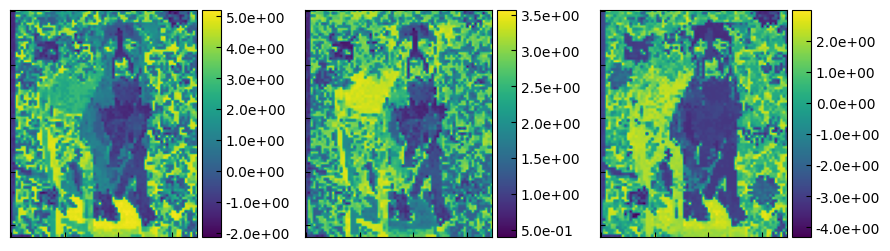

In [21]:
embedding_maps(encode, image)


* This is clearly an overcomplete example since we are learning 10 timesteps with 12 latent variables

# Generator
* Now we want to see how the spectra changes as we traverse the latent space

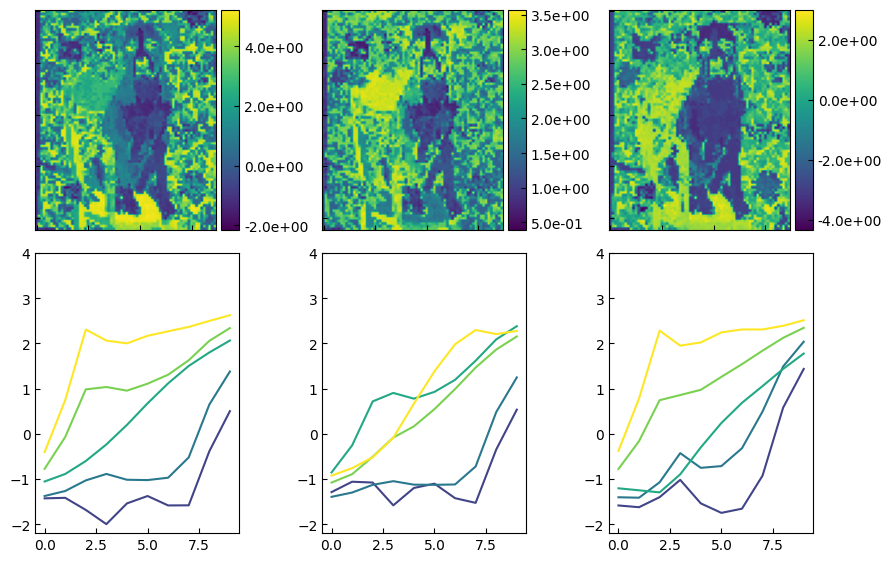

In [22]:
latent_generator(decoder, encode, image, 5, 10, device = device)


# Recurrent Neural Network Autoencoders
* The above example did not consider the temporal information in the data. 
* This can be improved by using a recurrent neural network that processes each time step sequentially.
* To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)

In [23]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


# LSTM Autoencoder with 12 latent dimensions

In [24]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [25]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [26]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:01<00:25,  1.42s/it]

100%|██████████| 19/19 [00:01<00:00, 12.86it/s]

Epoch 0, Train Loss: 1.9070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.92it/s]

Epoch 1, Train Loss: 1.9033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.47it/s]

Epoch 2, Train Loss: 1.8997
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.89it/s]

Epoch 3, Train Loss: 1.8961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.97it/s]

Epoch 4, Train Loss: 1.8926
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.51it/s]

Epoch 5, Train Loss: 1.8891
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.50it/s]

Epoch 6, Train Loss: 1.8856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.66it/s]

Epoch 7, Train Loss: 1.8822
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.11it/s]

Epoch 8, Train Loss: 1.8788
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.25it/s]

Epoch 9, Train Loss: 1.8754
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 10, Train Loss: 1.8720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 11, Train Loss: 1.8685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.93it/s]

Epoch 12, Train Loss: 1.8651
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.49it/s]

Epoch 13, Train Loss: 1.8617
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.05it/s]

Epoch 14, Train Loss: 1.8582
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 294.02it/s]

Epoch 15, Train Loss: 1.8547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.54it/s]

Epoch 16, Train Loss: 1.8511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.45it/s]

Epoch 17, Train Loss: 1.8474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.37it/s]

Epoch 18, Train Loss: 1.8437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.89it/s]

Epoch 19, Train Loss: 1.8399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.48it/s]

Epoch 20, Train Loss: 1.8359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.74it/s]

Epoch 21, Train Loss: 1.8319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.61it/s]

Epoch 22, Train Loss: 1.8276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.93it/s]

Epoch 23, Train Loss: 1.8233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.89it/s]

Epoch 24, Train Loss: 1.8187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.69it/s]

Epoch 25, Train Loss: 1.8140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.31it/s]

Epoch 26, Train Loss: 1.8090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 320.35it/s]

Epoch 27, Train Loss: 1.8038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.70it/s]

Epoch 28, Train Loss: 1.7983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.46it/s]

Epoch 29, Train Loss: 1.7925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.96it/s]

Epoch 30, Train Loss: 1.7864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.54it/s]

Epoch 31, Train Loss: 1.7799
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.10it/s]

Epoch 32, Train Loss: 1.7730
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 288.05it/s]

Epoch 33, Train Loss: 1.7657
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 288.01it/s]

Epoch 34, Train Loss: 1.7578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.71it/s]

Epoch 35, Train Loss: 1.7494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 36, Train Loss: 1.7404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 273.99it/s]

Epoch 37, Train Loss: 1.7308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 293.57it/s]

Epoch 38, Train Loss: 1.7204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.79it/s]

Epoch 39, Train Loss: 1.7093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.49it/s]

Epoch 40, Train Loss: 1.6973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 41, Train Loss: 1.6845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.39it/s]

Epoch 42, Train Loss: 1.6707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.42it/s]

Epoch 43, Train Loss: 1.6558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.59it/s]

Epoch 44, Train Loss: 1.6399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.62it/s]

Epoch 45, Train Loss: 1.6230
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.62it/s]

Epoch 46, Train Loss: 1.6049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 47, Train Loss: 1.5856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 48, Train Loss: 1.5652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.38it/s]

Epoch 49, Train Loss: 1.5437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.82it/s]

Epoch 50, Train Loss: 1.5210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.46it/s]

Epoch 51, Train Loss: 1.4974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 52, Train Loss: 1.4727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 277.83it/s]

Epoch 53, Train Loss: 1.4471
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 288.00it/s]

Epoch 54, Train Loss: 1.4208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.34it/s]

Epoch 55, Train Loss: 1.3936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.66it/s]

Epoch 56, Train Loss: 1.3659
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.78it/s]

Epoch 57, Train Loss: 1.3375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.64it/s]

Epoch 58, Train Loss: 1.3087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.43it/s]

Epoch 59, Train Loss: 1.2795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.13it/s]

Epoch 60, Train Loss: 1.2498
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.61it/s]

Epoch 61, Train Loss: 1.2199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.52it/s]

Epoch 62, Train Loss: 1.1898
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 63, Train Loss: 1.1595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.47it/s]

Epoch 64, Train Loss: 1.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.63it/s]

Epoch 65, Train Loss: 1.0986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 321.62it/s]

Epoch 66, Train Loss: 1.0681
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 67, Train Loss: 1.0377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.63it/s]

Epoch 68, Train Loss: 1.0074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.06it/s]

Epoch 69, Train Loss: 0.9772
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.68it/s]

Epoch 70, Train Loss: 0.9472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.51it/s]

Epoch 71, Train Loss: 0.9175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.43it/s]

Epoch 72, Train Loss: 0.8881
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.08it/s]

Epoch 73, Train Loss: 0.8591
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.52it/s]

Epoch 74, Train Loss: 0.8306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.62it/s]

Epoch 75, Train Loss: 0.8026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.57it/s]

Epoch 76, Train Loss: 0.7753
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.20it/s]

Epoch 77, Train Loss: 0.7486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.77it/s]

Epoch 78, Train Loss: 0.7227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 79, Train Loss: 0.6976
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.45it/s]

Epoch 80, Train Loss: 0.6735
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.82it/s]

Epoch 81, Train Loss: 0.6502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.45it/s]

Epoch 82, Train Loss: 0.6279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.40it/s]

Epoch 83, Train Loss: 0.6066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 84, Train Loss: 0.5862
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 85, Train Loss: 0.5668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.90it/s]

Epoch 86, Train Loss: 0.5484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.26it/s]

Epoch 87, Train Loss: 0.5308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 88, Train Loss: 0.5142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.21it/s]

Epoch 89, Train Loss: 0.4983
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.15it/s]

Epoch 90, Train Loss: 0.4832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.33it/s]

Epoch 91, Train Loss: 0.4688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 286.96it/s]

Epoch 92, Train Loss: 0.4551
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 93, Train Loss: 0.4421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 94, Train Loss: 0.4296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 95, Train Loss: 0.4177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.42it/s]

Epoch 96, Train Loss: 0.4063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.39it/s]

Epoch 97, Train Loss: 0.3954
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.93it/s]

Epoch 98, Train Loss: 0.3850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 305.87it/s]

Epoch 99, Train Loss: 0.3750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 286.57it/s]

Epoch 100, Train Loss: 0.3655
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 288.09it/s]

Epoch 101, Train Loss: 0.3563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.67it/s]

Epoch 102, Train Loss: 0.3476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.18it/s]

Epoch 103, Train Loss: 0.3393
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 310.87it/s]

Epoch 104, Train Loss: 0.3313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.86it/s]

Epoch 105, Train Loss: 0.3237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.49it/s]

Epoch 106, Train Loss: 0.3164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 107, Train Loss: 0.3094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.05it/s]

Epoch 108, Train Loss: 0.3028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.31it/s]

Epoch 109, Train Loss: 0.2965
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.10it/s]

Epoch 110, Train Loss: 0.2904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.52it/s]

Epoch 111, Train Loss: 0.2847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.37it/s]

Epoch 112, Train Loss: 0.2792
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.90it/s]

Epoch 113, Train Loss: 0.2739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.57it/s]

Epoch 114, Train Loss: 0.2689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.44it/s]

Epoch 115, Train Loss: 0.2642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 268.88it/s]

Epoch 116, Train Loss: 0.2597
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.47it/s]

Epoch 117, Train Loss: 0.2554
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.30it/s]

Epoch 118, Train Loss: 0.2513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.30it/s]

Epoch 119, Train Loss: 0.2474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.33it/s]

Epoch 120, Train Loss: 0.2437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.46it/s]

Epoch 121, Train Loss: 0.2402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.84it/s]

Epoch 122, Train Loss: 0.2369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.07it/s]

Epoch 123, Train Loss: 0.2338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.45it/s]

Epoch 124, Train Loss: 0.2308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 238.75it/s]

Epoch 125, Train Loss: 0.2279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 284.16it/s]

Epoch 126, Train Loss: 0.2252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.53it/s]

Epoch 127, Train Loss: 0.2227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 128, Train Loss: 0.2202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.94it/s]

Epoch 129, Train Loss: 0.2179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.87it/s]

Epoch 130, Train Loss: 0.2158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 261.47it/s]

Epoch 131, Train Loss: 0.2137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.56it/s]

Epoch 132, Train Loss: 0.2117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.25it/s]

Epoch 133, Train Loss: 0.2099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.50it/s]

Epoch 134, Train Loss: 0.2081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.44it/s]

Epoch 135, Train Loss: 0.2065
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.37it/s]

Epoch 136, Train Loss: 0.2049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.47it/s]

Epoch 137, Train Loss: 0.2034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 138, Train Loss: 0.2020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.51it/s]

Epoch 139, Train Loss: 0.2007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 288.53it/s]

Epoch 140, Train Loss: 0.1994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.59it/s]

Epoch 141, Train Loss: 0.1982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.77it/s]

Epoch 142, Train Loss: 0.1971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.32it/s]

Epoch 143, Train Loss: 0.1960
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.60it/s]

Epoch 144, Train Loss: 0.1950
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.18it/s]

Epoch 145, Train Loss: 0.1940
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.85it/s]

Epoch 146, Train Loss: 0.1931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.70it/s]

Epoch 147, Train Loss: 0.1923
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.44it/s]

Epoch 148, Train Loss: 0.1915
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.61it/s]

Epoch 149, Train Loss: 0.1907
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.08it/s]

Epoch 150, Train Loss: 0.1900
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 309.90it/s]

Epoch 151, Train Loss: 0.1893
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.12it/s]

Epoch 152, Train Loss: 0.1886
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.49it/s]

Epoch 153, Train Loss: 0.1880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.64it/s]

Epoch 154, Train Loss: 0.1874
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 300.38it/s]

Epoch 155, Train Loss: 0.1869
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.35it/s]

Epoch 156, Train Loss: 0.1863
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.40it/s]

Epoch 157, Train Loss: 0.1858
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.44it/s]

Epoch 158, Train Loss: 0.1854
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.23it/s]

Epoch 159, Train Loss: 0.1849
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.56it/s]

Epoch 160, Train Loss: 0.1845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.89it/s]

Epoch 161, Train Loss: 0.1841
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.68it/s]

Epoch 162, Train Loss: 0.1837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.49it/s]

Epoch 163, Train Loss: 0.1833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 291.57it/s]

Epoch 164, Train Loss: 0.1829
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.65it/s]

Epoch 165, Train Loss: 0.1826
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 166, Train Loss: 0.1823
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.53it/s]

Epoch 167, Train Loss: 0.1820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.24it/s]

Epoch 168, Train Loss: 0.1817
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 235.94it/s]

Epoch 169, Train Loss: 0.1814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.08it/s]

Epoch 170, Train Loss: 0.1811
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.60it/s]

Epoch 171, Train Loss: 0.1808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.56it/s]

Epoch 172, Train Loss: 0.1806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.14it/s]

Epoch 173, Train Loss: 0.1803
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.77it/s]

Epoch 174, Train Loss: 0.1801
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.92it/s]

Epoch 175, Train Loss: 0.1798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.38it/s]

Epoch 176, Train Loss: 0.1796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.87it/s]

Epoch 177, Train Loss: 0.1794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.89it/s]

Epoch 178, Train Loss: 0.1791
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.65it/s]

Epoch 179, Train Loss: 0.1789
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 286.13it/s]

Epoch 180, Train Loss: 0.1787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.51it/s]

Epoch 181, Train Loss: 0.1785
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.12it/s]

Epoch 182, Train Loss: 0.1783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.32it/s]

Epoch 183, Train Loss: 0.1781
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.89it/s]

Epoch 184, Train Loss: 0.1779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.13it/s]

Epoch 185, Train Loss: 0.1777
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.33it/s]

Epoch 186, Train Loss: 0.1776
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.32it/s]

Epoch 187, Train Loss: 0.1774
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.51it/s]

Epoch 188, Train Loss: 0.1772
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.71it/s]

Epoch 189, Train Loss: 0.1770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.42it/s]

Epoch 190, Train Loss: 0.1768
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.18it/s]

Epoch 191, Train Loss: 0.1767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.43it/s]

Epoch 192, Train Loss: 0.1765
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.46it/s]

Epoch 193, Train Loss: 0.1763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 310.49it/s]

Epoch 194, Train Loss: 0.1761
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 195, Train Loss: 0.1760
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.18it/s]

Epoch 196, Train Loss: 0.1758
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.33it/s]

Epoch 197, Train Loss: 0.1756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.85it/s]

Epoch 198, Train Loss: 0.1755
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.78it/s]

Epoch 199, Train Loss: 0.1753
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 288.16it/s]

Epoch 200, Train Loss: 0.1751
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.14it/s]

Epoch 201, Train Loss: 0.1750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.94it/s]

Epoch 202, Train Loss: 0.1748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.38it/s]

Epoch 203, Train Loss: 0.1746
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.50it/s]

Epoch 204, Train Loss: 0.1745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.90it/s]

Epoch 205, Train Loss: 0.1743
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.32it/s]

Epoch 206, Train Loss: 0.1741
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.75it/s]

Epoch 207, Train Loss: 0.1740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.28it/s]

Epoch 208, Train Loss: 0.1738
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.24it/s]

Epoch 209, Train Loss: 0.1736
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.75it/s]

Epoch 210, Train Loss: 0.1735
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.34it/s]

Epoch 211, Train Loss: 0.1733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.42it/s]

Epoch 212, Train Loss: 0.1731
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.28it/s]

Epoch 213, Train Loss: 0.1730
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.80it/s]

Epoch 214, Train Loss: 0.1728
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.64it/s]

Epoch 215, Train Loss: 0.1726
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.28it/s]

Epoch 216, Train Loss: 0.1725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.16it/s]

Epoch 217, Train Loss: 0.1723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.64it/s]

Epoch 218, Train Loss: 0.1721
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.67it/s]

Epoch 219, Train Loss: 0.1720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.53it/s]

Epoch 220, Train Loss: 0.1718
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 309.95it/s]

Epoch 221, Train Loss: 0.1716
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.87it/s]

Epoch 222, Train Loss: 0.1714
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.21it/s]

Epoch 223, Train Loss: 0.1713
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.38it/s]

Epoch 224, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.95it/s]

Epoch 225, Train Loss: 0.1709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 226, Train Loss: 0.1707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 227, Train Loss: 0.1706
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.43it/s]

Epoch 228, Train Loss: 0.1704
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 229, Train Loss: 0.1702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.70it/s]

Epoch 230, Train Loss: 0.1700
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.10it/s]

Epoch 231, Train Loss: 0.1698
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.95it/s]

Epoch 232, Train Loss: 0.1697
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.65it/s]

Epoch 233, Train Loss: 0.1695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.72it/s]

Epoch 234, Train Loss: 0.1693
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.04it/s]

Epoch 235, Train Loss: 0.1691
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.86it/s]

Epoch 236, Train Loss: 0.1689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.43it/s]

Epoch 237, Train Loss: 0.1687
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.42it/s]

Epoch 238, Train Loss: 0.1685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.53it/s]

Epoch 239, Train Loss: 0.1683
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.50it/s]

Epoch 240, Train Loss: 0.1681
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.73it/s]

Epoch 241, Train Loss: 0.1679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.73it/s]

Epoch 242, Train Loss: 0.1677
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 243, Train Loss: 0.1675
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.53it/s]

Epoch 244, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.60it/s]

Epoch 245, Train Loss: 0.1671
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.89it/s]

Epoch 246, Train Loss: 0.1669
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.40it/s]

Epoch 247, Train Loss: 0.1667
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.48it/s]

Epoch 248, Train Loss: 0.1665
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 284.73it/s]

Epoch 249, Train Loss: 0.1663
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.79it/s]

Epoch 250, Train Loss: 0.1660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 251, Train Loss: 0.1658
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.15it/s]

Epoch 252, Train Loss: 0.1656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.24it/s]

Epoch 253, Train Loss: 0.1654
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.54it/s]

Epoch 254, Train Loss: 0.1652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.70it/s]

Epoch 255, Train Loss: 0.1649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 293.27it/s]

Epoch 256, Train Loss: 0.1647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.60it/s]

Epoch 257, Train Loss: 0.1645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 258, Train Loss: 0.1642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 259, Train Loss: 0.1640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.43it/s]

Epoch 260, Train Loss: 0.1637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.73it/s]

Epoch 261, Train Loss: 0.1635
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 303.60it/s]

Epoch 262, Train Loss: 0.1633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 305.90it/s]

Epoch 263, Train Loss: 0.1630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.86it/s]

Epoch 264, Train Loss: 0.1628
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.36it/s]

Epoch 265, Train Loss: 0.1625
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 266, Train Loss: 0.1622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.49it/s]

Epoch 267, Train Loss: 0.1620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 321.99it/s]

Epoch 268, Train Loss: 0.1617
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 269, Train Loss: 0.1615
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.62it/s]

Epoch 270, Train Loss: 0.1612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.69it/s]

Epoch 271, Train Loss: 0.1609
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.69it/s]

Epoch 272, Train Loss: 0.1607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.46it/s]

Epoch 273, Train Loss: 0.1604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.43it/s]

Epoch 274, Train Loss: 0.1601
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.38it/s]

Epoch 275, Train Loss: 0.1599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.84it/s]

Epoch 276, Train Loss: 0.1596
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 293.86it/s]

Epoch 277, Train Loss: 0.1593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 278, Train Loss: 0.1590
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 279, Train Loss: 0.1588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 280, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 281, Train Loss: 0.1582
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 282, Train Loss: 0.1579
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 283, Train Loss: 0.1577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 284, Train Loss: 0.1574
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 285, Train Loss: 0.1571
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 286, Train Loss: 0.1568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 287, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 288, Train Loss: 0.1563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 289.94it/s]

Epoch 289, Train Loss: 0.1560
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 290, Train Loss: 0.1557
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 291, Train Loss: 0.1554
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 292, Train Loss: 0.1552
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.66it/s]

Epoch 293, Train Loss: 0.1549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.42it/s]

Epoch 294, Train Loss: 0.1546
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 295, Train Loss: 0.1543
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.47it/s]

Epoch 296, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 297, Train Loss: 0.1538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 298, Train Loss: 0.1535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 274.74it/s]

Epoch 299, Train Loss: 0.1532
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.44it/s]

Epoch 300, Train Loss: 0.1529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.33it/s]

Epoch 301, Train Loss: 0.1527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 302, Train Loss: 0.1524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.39it/s]

Epoch 303, Train Loss: 0.1521
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 304, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.50it/s]

Epoch 305, Train Loss: 0.1516
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.32it/s]

Epoch 306, Train Loss: 0.1513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.40it/s]

Epoch 307, Train Loss: 0.1510
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.48it/s]

Epoch 308, Train Loss: 0.1507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.24it/s]

Epoch 309, Train Loss: 0.1505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.91it/s]

Epoch 310, Train Loss: 0.1502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.40it/s]

Epoch 311, Train Loss: 0.1499
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.74it/s]

Epoch 312, Train Loss: 0.1496
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 298.89it/s]

Epoch 313, Train Loss: 0.1494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.64it/s]

Epoch 314, Train Loss: 0.1491
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.76it/s]

Epoch 315, Train Loss: 0.1488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.87it/s]

Epoch 316, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.43it/s]

Epoch 317, Train Loss: 0.1483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.53it/s]

Epoch 318, Train Loss: 0.1480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.45it/s]

Epoch 319, Train Loss: 0.1478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.43it/s]

Epoch 320, Train Loss: 0.1475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.69it/s]

Epoch 321, Train Loss: 0.1473
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.44it/s]

Epoch 322, Train Loss: 0.1470
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.69it/s]

Epoch 323, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.61it/s]

Epoch 324, Train Loss: 0.1465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 303.24it/s]

Epoch 325, Train Loss: 0.1462
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.39it/s]

Epoch 326, Train Loss: 0.1460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.96it/s]

Epoch 327, Train Loss: 0.1457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.61it/s]

Epoch 328, Train Loss: 0.1455
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 293.34it/s]

Epoch 329, Train Loss: 0.1452
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 330, Train Loss: 0.1450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.60it/s]

Epoch 331, Train Loss: 0.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.86it/s]

Epoch 332, Train Loss: 0.1445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.34it/s]

Epoch 333, Train Loss: 0.1443
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.60it/s]

Epoch 334, Train Loss: 0.1440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.03it/s]

Epoch 335, Train Loss: 0.1438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.43it/s]

Epoch 336, Train Loss: 0.1435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.22it/s]

Epoch 337, Train Loss: 0.1433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.85it/s]

Epoch 338, Train Loss: 0.1431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.42it/s]

Epoch 339, Train Loss: 0.1428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.41it/s]

Epoch 340, Train Loss: 0.1426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.40it/s]

Epoch 341, Train Loss: 0.1424
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.33it/s]

Epoch 342, Train Loss: 0.1422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.69it/s]

Epoch 343, Train Loss: 0.1419
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.82it/s]

Epoch 344, Train Loss: 0.1417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 345, Train Loss: 0.1415
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 346, Train Loss: 0.1413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 347, Train Loss: 0.1411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 348, Train Loss: 0.1409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 349, Train Loss: 0.1406
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 350, Train Loss: 0.1404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 351, Train Loss: 0.1402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 352, Train Loss: 0.1400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 353, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 354, Train Loss: 0.1396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 355, Train Loss: 0.1394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 356, Train Loss: 0.1392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 357, Train Loss: 0.1390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 358, Train Loss: 0.1388
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 359, Train Loss: 0.1386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.81it/s]

Epoch 360, Train Loss: 0.1384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 361, Train Loss: 0.1382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 362, Train Loss: 0.1380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 363, Train Loss: 0.1378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 364, Train Loss: 0.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 365, Train Loss: 0.1374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 366, Train Loss: 0.1372
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 367, Train Loss: 0.1370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.79it/s]

Epoch 368, Train Loss: 0.1369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.86it/s]

Epoch 369, Train Loss: 0.1367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 370, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 371, Train Loss: 0.1363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 372, Train Loss: 0.1361
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 373, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 374, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 375, Train Loss: 0.1355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.48it/s]

Epoch 376, Train Loss: 0.1354
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 377, Train Loss: 0.1352
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 378, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 379, Train Loss: 0.1348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 380, Train Loss: 0.1346
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 381, Train Loss: 0.1344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 382, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 383, Train Loss: 0.1341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.52it/s]

Epoch 384, Train Loss: 0.1339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 385, Train Loss: 0.1337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 386, Train Loss: 0.1335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 387, Train Loss: 0.1334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 321.87it/s]

Epoch 388, Train Loss: 0.1332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.30it/s]

Epoch 389, Train Loss: 0.1330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.32it/s]

Epoch 390, Train Loss: 0.1328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.39it/s]

Epoch 391, Train Loss: 0.1326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.50it/s]

Epoch 392, Train Loss: 0.1324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.55it/s]

Epoch 393, Train Loss: 0.1323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.48it/s]

Epoch 394, Train Loss: 0.1321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 395, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 321.80it/s]

Epoch 396, Train Loss: 0.1317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.68it/s]

Epoch 397, Train Loss: 0.1315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.63it/s]

Epoch 398, Train Loss: 0.1313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.56it/s]

Epoch 399, Train Loss: 0.1312
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 315.32it/s]

Epoch 400, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 321.81it/s]

Epoch 401, Train Loss: 0.1308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.69it/s]

Epoch 402, Train Loss: 0.1306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.15it/s]

Epoch 403, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.29it/s]

Epoch 404, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.65it/s]

Epoch 405, Train Loss: 0.1301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 406, Train Loss: 0.1299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 407, Train Loss: 0.1297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 408, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 409, Train Loss: 0.1293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 298.29it/s]

Epoch 410, Train Loss: 0.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 411, Train Loss: 0.1290
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 412, Train Loss: 0.1288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.02it/s]

Epoch 413, Train Loss: 0.1286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.91it/s]

Epoch 414, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 276.61it/s]

Epoch 415, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.84it/s]

Epoch 416, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.42it/s]

Epoch 417, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.44it/s]

Epoch 418, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.44it/s]

Epoch 419, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.31it/s]

Epoch 420, Train Loss: 0.1273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 421, Train Loss: 0.1271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.33it/s]

Epoch 422, Train Loss: 0.1269
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.35it/s]

Epoch 423, Train Loss: 0.1267
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.97it/s]

Epoch 424, Train Loss: 0.1265
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.91it/s]

Epoch 425, Train Loss: 0.1263
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.39it/s]

Epoch 426, Train Loss: 0.1261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 427, Train Loss: 0.1260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.51it/s]

Epoch 428, Train Loss: 0.1258
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.18it/s]

Epoch 429, Train Loss: 0.1256
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 430, Train Loss: 0.1254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.64it/s]

Epoch 431, Train Loss: 0.1252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.63it/s]

Epoch 432, Train Loss: 0.1250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.61it/s]

Epoch 433, Train Loss: 0.1248
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.68it/s]

Epoch 434, Train Loss: 0.1246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.44it/s]

Epoch 435, Train Loss: 0.1244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.46it/s]

Epoch 436, Train Loss: 0.1243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.64it/s]

Epoch 437, Train Loss: 0.1241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.66it/s]

Epoch 438, Train Loss: 0.1239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.58it/s]

Epoch 439, Train Loss: 0.1237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.40it/s]

Epoch 440, Train Loss: 0.1235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.49it/s]

Epoch 441, Train Loss: 0.1233
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.24it/s]

Epoch 442, Train Loss: 0.1231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.26it/s]

Epoch 443, Train Loss: 0.1229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.69it/s]

Epoch 444, Train Loss: 0.1227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.00it/s]

Epoch 445, Train Loss: 0.1225
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 446, Train Loss: 0.1223
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.44it/s]

Epoch 447, Train Loss: 0.1222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.29it/s]

Epoch 448, Train Loss: 0.1220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.16it/s]

Epoch 449, Train Loss: 0.1218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.60it/s]

Epoch 450, Train Loss: 0.1216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.66it/s]

Epoch 451, Train Loss: 0.1214
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.85it/s]

Epoch 452, Train Loss: 0.1212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.39it/s]

Epoch 453, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.79it/s]

Epoch 454, Train Loss: 0.1208
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.73it/s]

Epoch 455, Train Loss: 0.1206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 321.76it/s]

Epoch 456, Train Loss: 0.1204
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 457, Train Loss: 0.1202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.62it/s]

Epoch 458, Train Loss: 0.1200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.62it/s]

Epoch 459, Train Loss: 0.1199
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.44it/s]

Epoch 460, Train Loss: 0.1197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.53it/s]

Epoch 461, Train Loss: 0.1195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.74it/s]

Epoch 462, Train Loss: 0.1193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 302.68it/s]

Epoch 463, Train Loss: 0.1191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.61it/s]

Epoch 464, Train Loss: 0.1189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.30it/s]

Epoch 465, Train Loss: 0.1187
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.37it/s]

Epoch 466, Train Loss: 0.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.17it/s]

Epoch 467, Train Loss: 0.1183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.03it/s]

Epoch 468, Train Loss: 0.1181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.42it/s]

Epoch 469, Train Loss: 0.1179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.40it/s]

Epoch 470, Train Loss: 0.1177
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 286.98it/s]

Epoch 471, Train Loss: 0.1175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 472, Train Loss: 0.1173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.91it/s]

Epoch 473, Train Loss: 0.1172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.85it/s]

Epoch 474, Train Loss: 0.1170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.42it/s]

Epoch 475, Train Loss: 0.1168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.85it/s]

Epoch 476, Train Loss: 0.1166
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.08it/s]

Epoch 477, Train Loss: 0.1164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.40it/s]

Epoch 478, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.84it/s]

Epoch 479, Train Loss: 0.1160
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.52it/s]

Epoch 480, Train Loss: 0.1158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.42it/s]

Epoch 481, Train Loss: 0.1156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.03it/s]

Epoch 482, Train Loss: 0.1154
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 483, Train Loss: 0.1152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 484, Train Loss: 0.1150
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.04it/s]

Epoch 485, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.04it/s]

Epoch 486, Train Loss: 0.1146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 487, Train Loss: 0.1144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 488, Train Loss: 0.1142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.82it/s]

Epoch 489, Train Loss: 0.1140
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 282.36it/s]

Epoch 490, Train Loss: 0.1138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 291.50it/s]

Epoch 491, Train Loss: 0.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 278.70it/s]

Epoch 492, Train Loss: 0.1134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 286.59it/s]

Epoch 493, Train Loss: 0.1132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.60it/s]

Epoch 494, Train Loss: 0.1130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 300.15it/s]

Epoch 495, Train Loss: 0.1128
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 496, Train Loss: 0.1126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 497, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 498, Train Loss: 0.1122
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.73it/s]

Epoch 499, Train Loss: 0.1120
.............................


In [27]:
encode, decode = transform_nn(dog_data, encoder, decoder, device= device)


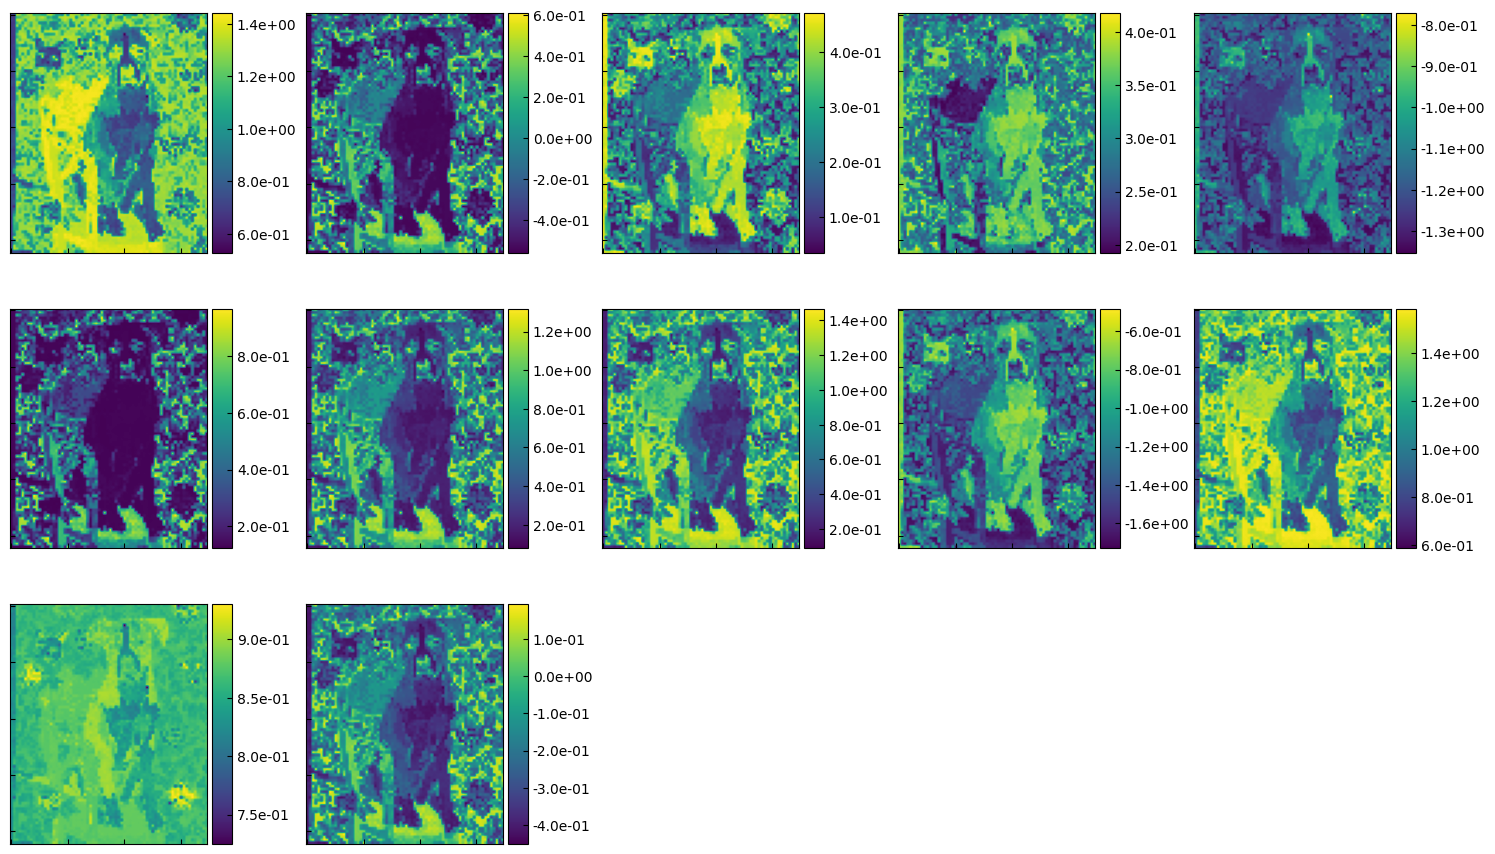

In [28]:
embedding_maps(encode, image)


* This does not really mean too much because the latent variables are all competing with one another

# Let's Try with 3 latent variables

In [29]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [30]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [31]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [32]:
torch.manual_seed(0)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device = device)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 278.86it/s]

Epoch 0, Train Loss: 2.1234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.47it/s]

Epoch 1, Train Loss: 2.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.69it/s]

Epoch 2, Train Loss: 2.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.66it/s]

Epoch 3, Train Loss: 2.1085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.87it/s]

Epoch 4, Train Loss: 2.1035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.56it/s]

Epoch 5, Train Loss: 2.0984
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.60it/s]

Epoch 6, Train Loss: 2.0933
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.50it/s]

Epoch 7, Train Loss: 2.0882
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.49it/s]

Epoch 8, Train Loss: 2.0830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 9, Train Loss: 2.0777
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.58it/s]

Epoch 10, Train Loss: 2.0724
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.37it/s]

Epoch 11, Train Loss: 2.0670
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.45it/s]

Epoch 12, Train Loss: 2.0616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.34it/s]

Epoch 13, Train Loss: 2.0561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 295.99it/s]

Epoch 14, Train Loss: 2.0506
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 15, Train Loss: 2.0449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.95it/s]

Epoch 16, Train Loss: 2.0392
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.89it/s]

Epoch 17, Train Loss: 2.0334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.68it/s]

Epoch 18, Train Loss: 2.0275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 19, Train Loss: 2.0216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.75it/s]

Epoch 20, Train Loss: 2.0155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.69it/s]

Epoch 21, Train Loss: 2.0094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 293.24it/s]

Epoch 22, Train Loss: 2.0031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.40it/s]

Epoch 23, Train Loss: 1.9967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.63it/s]

Epoch 24, Train Loss: 1.9903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.42it/s]

Epoch 25, Train Loss: 1.9837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.28it/s]

Epoch 26, Train Loss: 1.9770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.47it/s]

Epoch 27, Train Loss: 1.9702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.84it/s]

Epoch 28, Train Loss: 1.9632
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.61it/s]

Epoch 29, Train Loss: 1.9562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.42it/s]

Epoch 30, Train Loss: 1.9490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.63it/s]

Epoch 31, Train Loss: 1.9417
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.94it/s]

Epoch 32, Train Loss: 1.9342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.72it/s]

Epoch 33, Train Loss: 1.9266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.14it/s]

Epoch 34, Train Loss: 1.9189
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.93it/s]

Epoch 35, Train Loss: 1.9111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.73it/s]

Epoch 36, Train Loss: 1.9031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 37, Train Loss: 1.8949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.48it/s]

Epoch 38, Train Loss: 1.8867
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.57it/s]

Epoch 39, Train Loss: 1.8782
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 40, Train Loss: 1.8697
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.68it/s]

Epoch 41, Train Loss: 1.8610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.50it/s]

Epoch 42, Train Loss: 1.8522
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.35it/s]

Epoch 43, Train Loss: 1.8433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.86it/s]

Epoch 44, Train Loss: 1.8342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.26it/s]

Epoch 45, Train Loss: 1.8250
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.22it/s]

Epoch 46, Train Loss: 1.8156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.36it/s]

Epoch 47, Train Loss: 1.8062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.33it/s]

Epoch 48, Train Loss: 1.7966
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.34it/s]

Epoch 49, Train Loss: 1.7869
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.56it/s]

Epoch 50, Train Loss: 1.7770
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 295.33it/s]

Epoch 51, Train Loss: 1.7671
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.37it/s]

Epoch 52, Train Loss: 1.7570
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.49it/s]

Epoch 53, Train Loss: 1.7468
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.85it/s]

Epoch 54, Train Loss: 1.7365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.43it/s]

Epoch 55, Train Loss: 1.7260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.47it/s]

Epoch 56, Train Loss: 1.7155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.86it/s]

Epoch 57, Train Loss: 1.7049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 300.59it/s]

Epoch 58, Train Loss: 1.6941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.86it/s]

Epoch 59, Train Loss: 1.6833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.63it/s]

Epoch 60, Train Loss: 1.6723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.95it/s]

Epoch 61, Train Loss: 1.6613
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 62, Train Loss: 1.6503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.29it/s]

Epoch 63, Train Loss: 1.6391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.47it/s]

Epoch 64, Train Loss: 1.6279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.35it/s]

Epoch 65, Train Loss: 1.6167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.55it/s]

Epoch 66, Train Loss: 1.6054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.92it/s]

Epoch 67, Train Loss: 1.5942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.70it/s]

Epoch 68, Train Loss: 1.5829
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.17it/s]

Epoch 69, Train Loss: 1.5717
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 295.96it/s]

Epoch 70, Train Loss: 1.5605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 71, Train Loss: 1.5493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.73it/s]

Epoch 72, Train Loss: 1.5382
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 73, Train Loss: 1.5272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 295.98it/s]

Epoch 74, Train Loss: 1.5162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.86it/s]

Epoch 75, Train Loss: 1.5052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 76, Train Loss: 1.4943
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.57it/s]

Epoch 77, Train Loss: 1.4835
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.20it/s]

Epoch 78, Train Loss: 1.4727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.44it/s]

Epoch 79, Train Loss: 1.4620
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.12it/s]

Epoch 80, Train Loss: 1.4512
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.65it/s]

Epoch 81, Train Loss: 1.4405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.89it/s]

Epoch 82, Train Loss: 1.4298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.66it/s]

Epoch 83, Train Loss: 1.4191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.89it/s]

Epoch 84, Train Loss: 1.4084
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.81it/s]

Epoch 85, Train Loss: 1.3976
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 86, Train Loss: 1.3868
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.28it/s]

Epoch 87, Train Loss: 1.3759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 88, Train Loss: 1.3650
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 89, Train Loss: 1.3539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.28it/s]

Epoch 90, Train Loss: 1.3428
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 91, Train Loss: 1.3315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.74it/s]

Epoch 92, Train Loss: 1.3201
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.86it/s]

Epoch 93, Train Loss: 1.3086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 300.83it/s]

Epoch 94, Train Loss: 1.2969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 95, Train Loss: 1.2851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.15it/s]

Epoch 96, Train Loss: 1.2731
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.56it/s]

Epoch 97, Train Loss: 1.2610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.97it/s]

Epoch 98, Train Loss: 1.2487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.74it/s]

Epoch 99, Train Loss: 1.2363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 291.70it/s]

Epoch 100, Train Loss: 1.2237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.72it/s]

Epoch 101, Train Loss: 1.2110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.29it/s]

Epoch 102, Train Loss: 1.1981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.55it/s]

Epoch 103, Train Loss: 1.1851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.62it/s]

Epoch 104, Train Loss: 1.1720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.34it/s]

Epoch 105, Train Loss: 1.1587
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.43it/s]

Epoch 106, Train Loss: 1.1453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.35it/s]

Epoch 107, Train Loss: 1.1318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.49it/s]

Epoch 108, Train Loss: 1.1183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 298.32it/s]

Epoch 109, Train Loss: 1.1046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 110, Train Loss: 1.0909
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.67it/s]

Epoch 111, Train Loss: 1.0771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 291.76it/s]

Epoch 112, Train Loss: 1.0633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.71it/s]

Epoch 113, Train Loss: 1.0495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.84it/s]

Epoch 114, Train Loss: 1.0357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 294.59it/s]

Epoch 115, Train Loss: 1.0218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.29it/s]

Epoch 116, Train Loss: 1.0080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.28it/s]

Epoch 117, Train Loss: 0.9942
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.99it/s]

Epoch 118, Train Loss: 0.9805
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.79it/s]

Epoch 119, Train Loss: 0.9668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 278.72it/s]

Epoch 120, Train Loss: 0.9531
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.62it/s]

Epoch 121, Train Loss: 0.9396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.61it/s]

Epoch 122, Train Loss: 0.9261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.51it/s]

Epoch 123, Train Loss: 0.9127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.04it/s]

Epoch 124, Train Loss: 0.8995
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 125, Train Loss: 0.8863
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.75it/s]

Epoch 126, Train Loss: 0.8733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.79it/s]

Epoch 127, Train Loss: 0.8603
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 128, Train Loss: 0.8475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.42it/s]

Epoch 129, Train Loss: 0.8348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 293.55it/s]

Epoch 130, Train Loss: 0.8222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.17it/s]

Epoch 131, Train Loss: 0.8097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.70it/s]

Epoch 132, Train Loss: 0.7973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 133, Train Loss: 0.7851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 134, Train Loss: 0.7729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.44it/s]

Epoch 135, Train Loss: 0.7609
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.04it/s]

Epoch 136, Train Loss: 0.7489
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.76it/s]

Epoch 137, Train Loss: 0.7371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.04it/s]

Epoch 138, Train Loss: 0.7254
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.34it/s]

Epoch 139, Train Loss: 0.7137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 286.93it/s]

Epoch 140, Train Loss: 0.7022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 141, Train Loss: 0.6908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.74it/s]

Epoch 142, Train Loss: 0.6794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.66it/s]

Epoch 143, Train Loss: 0.6682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.20it/s]

Epoch 144, Train Loss: 0.6570
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.87it/s]

Epoch 145, Train Loss: 0.6460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 146, Train Loss: 0.6351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 147, Train Loss: 0.6243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.50it/s]

Epoch 148, Train Loss: 0.6136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 291.02it/s]

Epoch 149, Train Loss: 0.6030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 150, Train Loss: 0.5925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 151, Train Loss: 0.5822
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 152, Train Loss: 0.5720
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 153, Train Loss: 0.5619
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 154, Train Loss: 0.5520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 294.70it/s]

Epoch 155, Train Loss: 0.5422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 156, Train Loss: 0.5326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 157, Train Loss: 0.5231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 158, Train Loss: 0.5138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 159, Train Loss: 0.5046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 160, Train Loss: 0.4956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 161, Train Loss: 0.4867
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 270.19it/s]

Epoch 162, Train Loss: 0.4780
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.70it/s]

Epoch 163, Train Loss: 0.4695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.73it/s]

Epoch 164, Train Loss: 0.4611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.90it/s]

Epoch 165, Train Loss: 0.4529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.89it/s]

Epoch 166, Train Loss: 0.4448
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.91it/s]

Epoch 167, Train Loss: 0.4369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 168, Train Loss: 0.4292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.80it/s]

Epoch 169, Train Loss: 0.4217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 298.15it/s]

Epoch 170, Train Loss: 0.4143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.92it/s]

Epoch 171, Train Loss: 0.4071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.77it/s]

Epoch 172, Train Loss: 0.4000
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.70it/s]

Epoch 173, Train Loss: 0.3931
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 174, Train Loss: 0.3864
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 280.20it/s]

Epoch 175, Train Loss: 0.3798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 176, Train Loss: 0.3734
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 177, Train Loss: 0.3672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.02it/s]

Epoch 178, Train Loss: 0.3611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.43it/s]

Epoch 179, Train Loss: 0.3552
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.61it/s]

Epoch 180, Train Loss: 0.3494
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.52it/s]

Epoch 181, Train Loss: 0.3438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.16it/s]

Epoch 182, Train Loss: 0.3383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.90it/s]

Epoch 183, Train Loss: 0.3330
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.21it/s]

Epoch 184, Train Loss: 0.3279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.46it/s]

Epoch 185, Train Loss: 0.3229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 186, Train Loss: 0.3180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.69it/s]

Epoch 187, Train Loss: 0.3133
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.43it/s]

Epoch 188, Train Loss: 0.3088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.56it/s]

Epoch 189, Train Loss: 0.3043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.73it/s]

Epoch 190, Train Loss: 0.3001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.71it/s]

Epoch 191, Train Loss: 0.2959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.70it/s]

Epoch 192, Train Loss: 0.2919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 193, Train Loss: 0.2880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 298.75it/s]

Epoch 194, Train Loss: 0.2842
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.94it/s]

Epoch 195, Train Loss: 0.2806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.26it/s]

Epoch 196, Train Loss: 0.2771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.46it/s]

Epoch 197, Train Loss: 0.2737
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.91it/s]

Epoch 198, Train Loss: 0.2704
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.62it/s]

Epoch 199, Train Loss: 0.2672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.57it/s]

Epoch 200, Train Loss: 0.2642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.63it/s]

Epoch 201, Train Loss: 0.2612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.15it/s]

Epoch 202, Train Loss: 0.2584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.00it/s]

Epoch 203, Train Loss: 0.2556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 204, Train Loss: 0.2530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.40it/s]

Epoch 205, Train Loss: 0.2505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.71it/s]

Epoch 206, Train Loss: 0.2480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.73it/s]

Epoch 207, Train Loss: 0.2456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 208, Train Loss: 0.2434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.90it/s]

Epoch 209, Train Loss: 0.2412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 300.73it/s]

Epoch 210, Train Loss: 0.2391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.30it/s]

Epoch 211, Train Loss: 0.2371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.11it/s]

Epoch 212, Train Loss: 0.2351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 213, Train Loss: 0.2332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.89it/s]

Epoch 214, Train Loss: 0.2314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.44it/s]

Epoch 215, Train Loss: 0.2297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 294.16it/s]

Epoch 216, Train Loss: 0.2280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.83it/s]

Epoch 217, Train Loss: 0.2264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 218, Train Loss: 0.2249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.75it/s]

Epoch 219, Train Loss: 0.2234
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 280.46it/s]

Epoch 220, Train Loss: 0.2220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 221, Train Loss: 0.2206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 282.83it/s]

Epoch 222, Train Loss: 0.2193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.28it/s]

Epoch 223, Train Loss: 0.2181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.31it/s]

Epoch 224, Train Loss: 0.2168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.24it/s]

Epoch 225, Train Loss: 0.2157
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.76it/s]

Epoch 226, Train Loss: 0.2146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.37it/s]

Epoch 227, Train Loss: 0.2135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.29it/s]

Epoch 228, Train Loss: 0.2124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.14it/s]

Epoch 229, Train Loss: 0.2114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 230, Train Loss: 0.2104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.95it/s]

Epoch 231, Train Loss: 0.2095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.02it/s]

Epoch 232, Train Loss: 0.2086
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.13it/s]

Epoch 233, Train Loss: 0.2077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.40it/s]

Epoch 234, Train Loss: 0.2069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.71it/s]

Epoch 235, Train Loss: 0.2061
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.64it/s]

Epoch 236, Train Loss: 0.2053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.38it/s]

Epoch 237, Train Loss: 0.2045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 238, Train Loss: 0.2038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.14it/s]

Epoch 239, Train Loss: 0.2030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.34it/s]

Epoch 240, Train Loss: 0.2023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.28it/s]

Epoch 241, Train Loss: 0.2016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.57it/s]

Epoch 242, Train Loss: 0.2010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.20it/s]

Epoch 243, Train Loss: 0.2003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.39it/s]

Epoch 244, Train Loss: 0.1997
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.71it/s]

Epoch 245, Train Loss: 0.1991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.56it/s]

Epoch 246, Train Loss: 0.1985
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.48it/s]

Epoch 247, Train Loss: 0.1979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.20it/s]

Epoch 248, Train Loss: 0.1973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.86it/s]

Epoch 249, Train Loss: 0.1967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 250, Train Loss: 0.1962
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.75it/s]

Epoch 251, Train Loss: 0.1956
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.38it/s]

Epoch 252, Train Loss: 0.1951
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 253, Train Loss: 0.1946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.36it/s]

Epoch 254, Train Loss: 0.1941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.89it/s]

Epoch 255, Train Loss: 0.1935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.33it/s]

Epoch 256, Train Loss: 0.1930
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 257, Train Loss: 0.1925
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 294.06it/s]

Epoch 258, Train Loss: 0.1921
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.90it/s]

Epoch 259, Train Loss: 0.1916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.73it/s]

Epoch 260, Train Loss: 0.1911
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.40it/s]

Epoch 261, Train Loss: 0.1906
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.76it/s]

Epoch 262, Train Loss: 0.1901
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.67it/s]

Epoch 263, Train Loss: 0.1897
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.43it/s]

Epoch 264, Train Loss: 0.1892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.92it/s]

Epoch 265, Train Loss: 0.1887
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 266, Train Loss: 0.1883
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 267, Train Loss: 0.1878
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.46it/s]

Epoch 268, Train Loss: 0.1874
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.46it/s]

Epoch 269, Train Loss: 0.1869
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 270, Train Loss: 0.1865
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.40it/s]

Epoch 271, Train Loss: 0.1860
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.45it/s]

Epoch 272, Train Loss: 0.1856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.69it/s]

Epoch 273, Train Loss: 0.1851
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 282.40it/s]

Epoch 274, Train Loss: 0.1847
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.55it/s]

Epoch 275, Train Loss: 0.1843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 276, Train Loss: 0.1838
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.62it/s]

Epoch 277, Train Loss: 0.1834
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.35it/s]

Epoch 278, Train Loss: 0.1830
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 279, Train Loss: 0.1825
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.42it/s]

Epoch 280, Train Loss: 0.1821
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.61it/s]

Epoch 281, Train Loss: 0.1817
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.49it/s]

Epoch 282, Train Loss: 0.1813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.47it/s]

Epoch 283, Train Loss: 0.1808
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 284, Train Loss: 0.1804
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.69it/s]

Epoch 285, Train Loss: 0.1800
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.32it/s]

Epoch 286, Train Loss: 0.1796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.53it/s]

Epoch 287, Train Loss: 0.1792
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.34it/s]

Epoch 288, Train Loss: 0.1787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.49it/s]

Epoch 289, Train Loss: 0.1783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.96it/s]

Epoch 290, Train Loss: 0.1779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 291, Train Loss: 0.1775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 273.20it/s]

Epoch 292, Train Loss: 0.1771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.83it/s]

Epoch 293, Train Loss: 0.1767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.17it/s]

Epoch 294, Train Loss: 0.1763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.74it/s]

Epoch 295, Train Loss: 0.1759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.85it/s]

Epoch 296, Train Loss: 0.1755
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.17it/s]

Epoch 297, Train Loss: 0.1751
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 291.44it/s]

Epoch 298, Train Loss: 0.1747
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.73it/s]

Epoch 299, Train Loss: 0.1743
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.23it/s]

Epoch 300, Train Loss: 0.1739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.21it/s]

Epoch 301, Train Loss: 0.1735
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.45it/s]

Epoch 302, Train Loss: 0.1731
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.08it/s]

Epoch 303, Train Loss: 0.1727
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.05it/s]

Epoch 304, Train Loss: 0.1723
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 280.09it/s]

Epoch 305, Train Loss: 0.1719
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 306, Train Loss: 0.1715
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 307, Train Loss: 0.1711
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.93it/s]

Epoch 308, Train Loss: 0.1707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.72it/s]

Epoch 309, Train Loss: 0.1703
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.11it/s]

Epoch 310, Train Loss: 0.1699
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.60it/s]

Epoch 311, Train Loss: 0.1695
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.16it/s]

Epoch 312, Train Loss: 0.1692
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.16it/s]

Epoch 313, Train Loss: 0.1688
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 285.93it/s]

Epoch 314, Train Loss: 0.1684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.42it/s]

Epoch 315, Train Loss: 0.1680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.31it/s]

Epoch 316, Train Loss: 0.1677
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.29it/s]

Epoch 317, Train Loss: 0.1673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.17it/s]

Epoch 318, Train Loss: 0.1669
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.26it/s]

Epoch 319, Train Loss: 0.1665
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.57it/s]

Epoch 320, Train Loss: 0.1662
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 321, Train Loss: 0.1658
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 291.50it/s]

Epoch 322, Train Loss: 0.1654
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 323, Train Loss: 0.1651
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 324, Train Loss: 0.1647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 325, Train Loss: 0.1643
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 326, Train Loss: 0.1640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 327, Train Loss: 0.1636
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 328, Train Loss: 0.1633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 329, Train Loss: 0.1629
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 330, Train Loss: 0.1626
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 331, Train Loss: 0.1622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 332, Train Loss: 0.1619
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.81it/s]

Epoch 333, Train Loss: 0.1615
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 334, Train Loss: 0.1612
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 335, Train Loss: 0.1608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 336, Train Loss: 0.1605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 337, Train Loss: 0.1602
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.23it/s]

Epoch 338, Train Loss: 0.1598
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 339, Train Loss: 0.1595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 340, Train Loss: 0.1592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 341, Train Loss: 0.1588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 342, Train Loss: 0.1585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 343, Train Loss: 0.1582
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 344, Train Loss: 0.1578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 345, Train Loss: 0.1575
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.81it/s]

Epoch 346, Train Loss: 0.1572
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 347, Train Loss: 0.1569
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 348, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 349, Train Loss: 0.1562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 350, Train Loss: 0.1559
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 351, Train Loss: 0.1556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 352, Train Loss: 0.1553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 353, Train Loss: 0.1550
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 354, Train Loss: 0.1547
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 355, Train Loss: 0.1544
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 356, Train Loss: 0.1541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 357, Train Loss: 0.1538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 358, Train Loss: 0.1535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 359, Train Loss: 0.1532
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 360, Train Loss: 0.1529
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.28it/s]

Epoch 361, Train Loss: 0.1526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.37it/s]

Epoch 362, Train Loss: 0.1523
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.47it/s]

Epoch 363, Train Loss: 0.1520
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 364, Train Loss: 0.1518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.13it/s]

Epoch 365, Train Loss: 0.1515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.42it/s]

Epoch 366, Train Loss: 0.1512
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.50it/s]

Epoch 367, Train Loss: 0.1509
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 368, Train Loss: 0.1506
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 369, Train Loss: 0.1503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 370, Train Loss: 0.1501
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 371, Train Loss: 0.1498
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 372, Train Loss: 0.1495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 373, Train Loss: 0.1493
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 374, Train Loss: 0.1490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 375, Train Loss: 0.1487
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 376, Train Loss: 0.1484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.24it/s]

Epoch 377, Train Loss: 0.1482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 378, Train Loss: 0.1479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 379, Train Loss: 0.1477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 380, Train Loss: 0.1474
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 381, Train Loss: 0.1471
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 382, Train Loss: 0.1469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 383, Train Loss: 0.1466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 384, Train Loss: 0.1464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 385, Train Loss: 0.1461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 386, Train Loss: 0.1459
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 387, Train Loss: 0.1456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 388, Train Loss: 0.1454
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.81it/s]

Epoch 389, Train Loss: 0.1451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 390, Train Loss: 0.1449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 391, Train Loss: 0.1446
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 392, Train Loss: 0.1444
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 393, Train Loss: 0.1442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 394, Train Loss: 0.1439
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.42it/s]

Epoch 395, Train Loss: 0.1437
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 396, Train Loss: 0.1434
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.36it/s]

Epoch 397, Train Loss: 0.1432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 398, Train Loss: 0.1430
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 399, Train Loss: 0.1427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 400, Train Loss: 0.1425
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 401, Train Loss: 0.1423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 402, Train Loss: 0.1421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 403, Train Loss: 0.1418
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.80it/s]

Epoch 404, Train Loss: 0.1416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 405, Train Loss: 0.1414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 406, Train Loss: 0.1412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 407, Train Loss: 0.1410
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 408, Train Loss: 0.1407
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.76it/s]

Epoch 409, Train Loss: 0.1405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 410, Train Loss: 0.1403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 411, Train Loss: 0.1401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 412, Train Loss: 0.1399
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 413, Train Loss: 0.1397
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 414, Train Loss: 0.1395
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 415, Train Loss: 0.1393
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 416, Train Loss: 0.1391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.81it/s]

Epoch 417, Train Loss: 0.1389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.30it/s]

Epoch 418, Train Loss: 0.1387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 419, Train Loss: 0.1385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 420, Train Loss: 0.1383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 421, Train Loss: 0.1381
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 422, Train Loss: 0.1379
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 423, Train Loss: 0.1377
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.24it/s]

Epoch 424, Train Loss: 0.1375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 425, Train Loss: 0.1373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 426, Train Loss: 0.1371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 427, Train Loss: 0.1369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.78it/s]

Epoch 428, Train Loss: 0.1368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 429, Train Loss: 0.1366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 430, Train Loss: 0.1364
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 431, Train Loss: 0.1362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 432, Train Loss: 0.1360
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.46it/s]

Epoch 433, Train Loss: 0.1359
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.66it/s]

Epoch 434, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 282.64it/s]

Epoch 435, Train Loss: 0.1355
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.75it/s]

Epoch 436, Train Loss: 0.1353
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.16it/s]

Epoch 437, Train Loss: 0.1352
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 297.12it/s]

Epoch 438, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.62it/s]

Epoch 439, Train Loss: 0.1348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.73it/s]

Epoch 440, Train Loss: 0.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.22it/s]

Epoch 441, Train Loss: 0.1345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 294.21it/s]

Epoch 442, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.97it/s]

Epoch 443, Train Loss: 0.1342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.40it/s]

Epoch 444, Train Loss: 0.1340
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.33it/s]

Epoch 445, Train Loss: 0.1339
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.61it/s]

Epoch 446, Train Loss: 0.1337
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.54it/s]

Epoch 447, Train Loss: 0.1336
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.28it/s]

Epoch 448, Train Loss: 0.1334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 449, Train Loss: 0.1332
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 37%|███▋      | 7/19 [00:00<00:00, 62.50it/s]

 79%|███████▉  | 15/19 [00:00<00:00, 67.05it/s]

100%|██████████| 19/19 [00:00<00:00, 70.11it/s]

Epoch 450, Train Loss: 0.1331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 178.81it/s]

100%|██████████| 19/19 [00:00<00:00, 181.53it/s]

Epoch 451, Train Loss: 0.1329
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 452, Train Loss: 0.1328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.79it/s]

Epoch 453, Train Loss: 0.1327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 454, Train Loss: 0.1325
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 455, Train Loss: 0.1324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 456, Train Loss: 0.1322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.80it/s]

Epoch 457, Train Loss: 0.1321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 458, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 459, Train Loss: 0.1318
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 460, Train Loss: 0.1317
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 461, Train Loss: 0.1315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.79it/s]

Epoch 462, Train Loss: 0.1314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 463, Train Loss: 0.1313
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 464, Train Loss: 0.1311
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 465, Train Loss: 0.1310
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 466, Train Loss: 0.1309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 467, Train Loss: 0.1307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 468, Train Loss: 0.1306
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 469, Train Loss: 0.1305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 470, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 471, Train Loss: 0.1302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 472, Train Loss: 0.1301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.48it/s]

Epoch 473, Train Loss: 0.1300
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 311.41it/s]

Epoch 474, Train Loss: 0.1299
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 322.04it/s]

Epoch 475, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 301.59it/s]

Epoch 476, Train Loss: 0.1296
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.45it/s]

Epoch 477, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 478, Train Loss: 0.1294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.88it/s]

Epoch 479, Train Loss: 0.1293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 480, Train Loss: 0.1292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 481, Train Loss: 0.1291
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 482, Train Loss: 0.1289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.44it/s]

Epoch 483, Train Loss: 0.1288
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 484, Train Loss: 0.1287
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 485, Train Loss: 0.1286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 486, Train Loss: 0.1285
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 487, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 306.38it/s]

Epoch 488, Train Loss: 0.1283
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 489, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.65it/s]

Epoch 490, Train Loss: 0.1280
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 491, Train Loss: 0.1279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 290.05it/s]

Epoch 492, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 292.31it/s]

Epoch 493, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.81it/s]

Epoch 494, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 495, Train Loss: 0.1275
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 496, Train Loss: 0.1274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 296.87it/s]

Epoch 497, Train Loss: 0.1273
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 316.67it/s]

Epoch 498, Train Loss: 0.1272
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 499, Train Loss: 0.1271
.............................


In [33]:
encode, decode = transform_nn(dog_data, encoder, decoder, device = device)


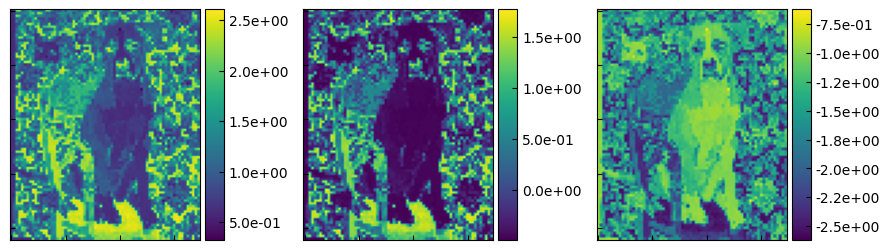

In [34]:
embedding_maps(encode, image)


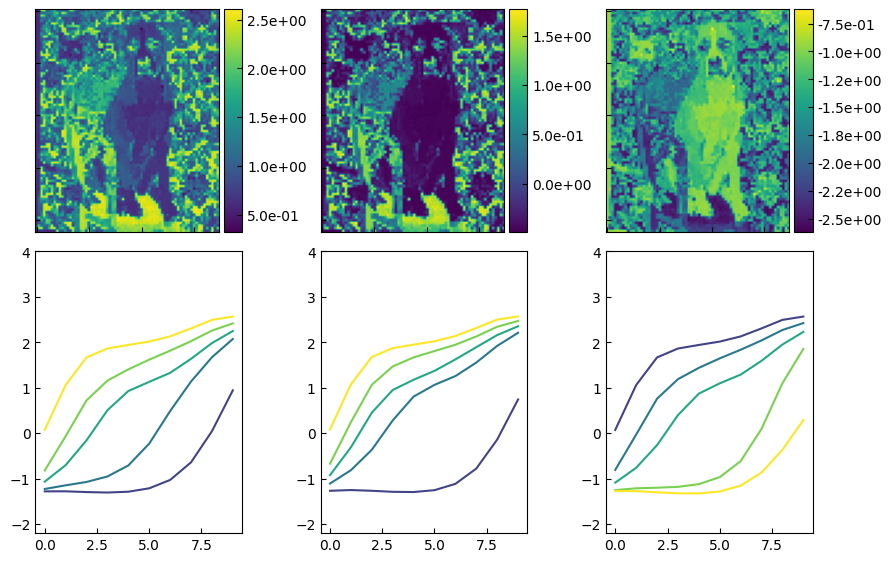

In [35]:
latent_generator(decoder, encode, image, 5, 10, device = device)


* This once again is very hard to interpret and the spectra do not really contain the necessary details

# Disentanglement
## Regularization
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/L1_reg.png?raw=true)


In [36]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [37]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [38]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [39]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [40]:
torch.manual_seed(0)
Train(
    model, encoder, decoder, train_iterator, optimizer, 500, coef=1e-3, mse=False, device=device,
)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 0, Train Loss: 2.1541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 1, Train Loss: 2.1475
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.16it/s]

Epoch 2, Train Loss: 2.1411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 3, Train Loss: 2.1347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 4, Train Loss: 2.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 5, Train Loss: 2.1221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.98it/s]

Epoch 6, Train Loss: 2.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 7, Train Loss: 2.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 8, Train Loss: 2.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 9, Train Loss: 2.0977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.35it/s]

Epoch 10, Train Loss: 2.0917
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.42it/s]

Epoch 11, Train Loss: 2.0857
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.37it/s]

Epoch 12, Train Loss: 2.0798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 13, Train Loss: 2.0739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 14, Train Loss: 2.0680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.78it/s]

Epoch 15, Train Loss: 2.0621
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 16, Train Loss: 2.0563
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.78it/s]

Epoch 17, Train Loss: 2.0504
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 18, Train Loss: 2.0445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.63it/s]

Epoch 19, Train Loss: 2.0386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.24it/s]

Epoch 20, Train Loss: 2.0327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 21, Train Loss: 2.0268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 22, Train Loss: 2.0209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.22it/s]

Epoch 23, Train Loss: 2.0149
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 24, Train Loss: 2.0089
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 25, Train Loss: 2.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 26, Train Loss: 1.9967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 27, Train Loss: 1.9906
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.37it/s]

Epoch 28, Train Loss: 1.9843
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 29, Train Loss: 1.9780
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 30, Train Loss: 1.9716
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 31, Train Loss: 1.9652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 32, Train Loss: 1.9586
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 33, Train Loss: 1.9523
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 34, Train Loss: 1.9463
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 35, Train Loss: 1.9405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.21it/s]

Epoch 36, Train Loss: 1.9348
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 37, Train Loss: 1.9292
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 38, Train Loss: 1.9237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 39, Train Loss: 1.9183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.17it/s]

Epoch 40, Train Loss: 1.9129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 41, Train Loss: 1.9076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 42, Train Loss: 1.9023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 43, Train Loss: 1.8974
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 44, Train Loss: 1.8928
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 45, Train Loss: 1.8883
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 46, Train Loss: 1.8838
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 47, Train Loss: 1.8794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 48, Train Loss: 1.8750
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 49, Train Loss: 1.8705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 50, Train Loss: 1.8661
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 51, Train Loss: 1.8617
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 52, Train Loss: 1.8572
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 53, Train Loss: 1.8527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 54, Train Loss: 1.8482
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 55, Train Loss: 1.8436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 56, Train Loss: 1.8389
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 57, Train Loss: 1.8342
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 58, Train Loss: 1.8294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.22it/s]

Epoch 59, Train Loss: 1.8245
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 60, Train Loss: 1.8196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 61, Train Loss: 1.8146
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 62, Train Loss: 1.8095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 63, Train Loss: 1.8042
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 64, Train Loss: 1.7989
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 65, Train Loss: 1.7935
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 66, Train Loss: 1.7880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 67, Train Loss: 1.7824
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 68, Train Loss: 1.7767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 69, Train Loss: 1.7709
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 70, Train Loss: 1.7650
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.29it/s]

Epoch 71, Train Loss: 1.7589
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.39it/s]

Epoch 72, Train Loss: 1.7527
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 255.57it/s]

Epoch 73, Train Loss: 1.7464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 74, Train Loss: 1.7400
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 75, Train Loss: 1.7334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 76, Train Loss: 1.7266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.01it/s]

Epoch 77, Train Loss: 1.7198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 78, Train Loss: 1.7127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 79, Train Loss: 1.7056
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 80, Train Loss: 1.6982
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 81, Train Loss: 1.6908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 82, Train Loss: 1.6832
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 83, Train Loss: 1.6757
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 84, Train Loss: 1.6682
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 85, Train Loss: 1.6607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 86, Train Loss: 1.6531
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 87, Train Loss: 1.6453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 88, Train Loss: 1.6374
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 89, Train Loss: 1.6294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 90, Train Loss: 1.6212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.42it/s]

Epoch 91, Train Loss: 1.6129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 92, Train Loss: 1.6044
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 93, Train Loss: 1.5959
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.15it/s]

Epoch 94, Train Loss: 1.5872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.20it/s]

Epoch 95, Train Loss: 1.5783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 96, Train Loss: 1.5694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 97, Train Loss: 1.5604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 98, Train Loss: 1.5513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.38it/s]

Epoch 99, Train Loss: 1.5421
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 100, Train Loss: 1.5328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 101, Train Loss: 1.5235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 102, Train Loss: 1.5141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 103, Train Loss: 1.5046
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 264.01it/s]

Epoch 104, Train Loss: 1.4951
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 105, Train Loss: 1.4856
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 106, Train Loss: 1.4760
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 107, Train Loss: 1.4664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 108, Train Loss: 1.4568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.27it/s]

Epoch 109, Train Loss: 1.4472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.34it/s]

Epoch 110, Train Loss: 1.4376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 111, Train Loss: 1.4279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 112, Train Loss: 1.4183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 113, Train Loss: 1.4087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.15it/s]

Epoch 114, Train Loss: 1.3991
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.35it/s]

Epoch 115, Train Loss: 1.3895
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 116, Train Loss: 1.3800
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 117, Train Loss: 1.3705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 118, Train Loss: 1.3610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 119, Train Loss: 1.3517
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 120, Train Loss: 1.3423
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 121, Train Loss: 1.3331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 273.30it/s]

Epoch 122, Train Loss: 1.3239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 123, Train Loss: 1.3148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 124, Train Loss: 1.3058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 125, Train Loss: 1.2969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 126, Train Loss: 1.2881
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 127, Train Loss: 1.2794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 128, Train Loss: 1.2708
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 129, Train Loss: 1.2623
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.17it/s]

Epoch 130, Train Loss: 1.2539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.81it/s]

Epoch 131, Train Loss: 1.2457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 132, Train Loss: 1.2376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.34it/s]

Epoch 133, Train Loss: 1.2297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 134, Train Loss: 1.2218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 135, Train Loss: 1.2141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 136, Train Loss: 1.2066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 137, Train Loss: 1.1992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 138, Train Loss: 1.1919
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 139, Train Loss: 1.1848
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 140, Train Loss: 1.1778
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 141, Train Loss: 1.1710
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 142, Train Loss: 1.1642
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 143, Train Loss: 1.1576
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 144, Train Loss: 1.1511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 145, Train Loss: 1.1447
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 146, Train Loss: 1.1384
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 147, Train Loss: 1.1322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 148, Train Loss: 1.1260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.68it/s]

Epoch 149, Train Loss: 1.1198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.65it/s]

Epoch 150, Train Loss: 1.1136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 151, Train Loss: 1.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 152, Train Loss: 1.1011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 153, Train Loss: 1.0948
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 154, Train Loss: 1.0884
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 155, Train Loss: 1.0820
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 156, Train Loss: 1.0758
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 157, Train Loss: 1.0696
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 158, Train Loss: 1.0634
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 159, Train Loss: 1.0571
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 160, Train Loss: 1.0507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.15it/s]

Epoch 161, Train Loss: 1.0442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 162, Train Loss: 1.0376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 163, Train Loss: 1.0308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.74it/s]

Epoch 164, Train Loss: 1.0239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 165, Train Loss: 1.0167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 258.47it/s]

Epoch 166, Train Loss: 1.0093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 167, Train Loss: 1.0016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 168, Train Loss: 0.9936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 169, Train Loss: 0.9852
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 170, Train Loss: 0.9765
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 171, Train Loss: 0.9674
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 172, Train Loss: 0.9578
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 173, Train Loss: 0.9477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 174, Train Loss: 0.9371
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 175, Train Loss: 0.9259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.76it/s]

Epoch 176, Train Loss: 0.9141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.16it/s]

Epoch 177, Train Loss: 0.9016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 257.82it/s]

Epoch 178, Train Loss: 0.8886
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 179, Train Loss: 0.8748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 258.20it/s]

Epoch 180, Train Loss: 0.8605
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 181, Train Loss: 0.8456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 182, Train Loss: 0.8301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 183, Train Loss: 0.8141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 184, Train Loss: 0.7979
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 185, Train Loss: 0.7813
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 186, Train Loss: 0.7647
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 187, Train Loss: 0.7481
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 188, Train Loss: 0.7315
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 189, Train Loss: 0.7152
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 190, Train Loss: 0.6992
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 191, Train Loss: 0.6836
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 192, Train Loss: 0.6685
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 193, Train Loss: 0.6539
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 194, Train Loss: 0.6398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.38it/s]

Epoch 195, Train Loss: 0.6262
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 196, Train Loss: 0.6132
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 197, Train Loss: 0.6007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.36it/s]

Epoch 198, Train Loss: 0.5889
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 199, Train Loss: 0.5778
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 200, Train Loss: 0.5673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 201, Train Loss: 0.5575
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.75it/s]

Epoch 202, Train Loss: 0.5483
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 203, Train Loss: 0.5396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 204, Train Loss: 0.5314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 205, Train Loss: 0.5237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 206, Train Loss: 0.5164
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 207, Train Loss: 0.5095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 208, Train Loss: 0.5029
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 209, Train Loss: 0.4967
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 210, Train Loss: 0.4907
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 211, Train Loss: 0.4850
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 212, Train Loss: 0.4796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 213, Train Loss: 0.4745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 214, Train Loss: 0.4696
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 215, Train Loss: 0.4649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 216, Train Loss: 0.4604
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 258.47it/s]

Epoch 217, Train Loss: 0.4560
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 218, Train Loss: 0.4519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 219, Train Loss: 0.4479
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 220, Train Loss: 0.4441
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 221, Train Loss: 0.4404
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.76it/s]

Epoch 222, Train Loss: 0.4369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 223, Train Loss: 0.4334
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.78it/s]

Epoch 224, Train Loss: 0.4302
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 211.11it/s]

Epoch 225, Train Loss: 0.4270
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 226, Train Loss: 0.4239
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 227, Train Loss: 0.4210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 228, Train Loss: 0.4181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 229, Train Loss: 0.4153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.35it/s]

Epoch 230, Train Loss: 0.4126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 231, Train Loss: 0.4100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 232, Train Loss: 0.4075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 233, Train Loss: 0.4050
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.57it/s]

Epoch 234, Train Loss: 0.4026
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 235, Train Loss: 0.4003
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 236, Train Loss: 0.3980
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 237, Train Loss: 0.3957
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.35it/s]

Epoch 238, Train Loss: 0.3936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 239, Train Loss: 0.3914
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 240, Train Loss: 0.3893
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 241, Train Loss: 0.3873
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 242, Train Loss: 0.3853
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 243, Train Loss: 0.3834
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 244, Train Loss: 0.3814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 245, Train Loss: 0.3796
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 246, Train Loss: 0.3777
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 247, Train Loss: 0.3759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.23it/s]

Epoch 248, Train Loss: 0.3741
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 249, Train Loss: 0.3724
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 250, Train Loss: 0.3706
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 251, Train Loss: 0.3689
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.70it/s]

Epoch 252, Train Loss: 0.3673
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 253, Train Loss: 0.3656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.65it/s]

Epoch 254, Train Loss: 0.3640
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.85it/s]

Epoch 255, Train Loss: 0.3624
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 256, Train Loss: 0.3608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 257, Train Loss: 0.3593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.39it/s]

Epoch 258, Train Loss: 0.3577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 259, Train Loss: 0.3562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 260, Train Loss: 0.3548
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.93it/s]

Epoch 261, Train Loss: 0.3533
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 262, Train Loss: 0.3519
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 263, Train Loss: 0.3505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 264, Train Loss: 0.3491
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.54it/s]

Epoch 265, Train Loss: 0.3477
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 266, Train Loss: 0.3464
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 267, Train Loss: 0.3451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 268, Train Loss: 0.3438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 269, Train Loss: 0.3426
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.56it/s]

Epoch 270, Train Loss: 0.3413
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 271, Train Loss: 0.3401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 258.34it/s]

Epoch 272, Train Loss: 0.3390
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 273, Train Loss: 0.3378
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 274, Train Loss: 0.3367
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 275, Train Loss: 0.3356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 276, Train Loss: 0.3345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 277, Train Loss: 0.3335
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 278, Train Loss: 0.3324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 279, Train Loss: 0.3314
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 280, Train Loss: 0.3305
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 281, Train Loss: 0.3295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 282, Train Loss: 0.3286
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 257.26it/s]

Epoch 283, Train Loss: 0.3277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 284, Train Loss: 0.3268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 285, Train Loss: 0.3259
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 286, Train Loss: 0.3251
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 287, Train Loss: 0.3243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 288, Train Loss: 0.3235
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 289, Train Loss: 0.3227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 290, Train Loss: 0.3220
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.43it/s]

Epoch 291, Train Loss: 0.3212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 292, Train Loss: 0.3205
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 293, Train Loss: 0.3198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 294, Train Loss: 0.3191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 295, Train Loss: 0.3184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 296, Train Loss: 0.3178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 297, Train Loss: 0.3171
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.52it/s]

Epoch 298, Train Loss: 0.3165
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 299, Train Loss: 0.3159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 300, Train Loss: 0.3153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 301, Train Loss: 0.3147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 302, Train Loss: 0.3142
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 303, Train Loss: 0.3136
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.39it/s]

Epoch 304, Train Loss: 0.3130
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.93it/s]

Epoch 305, Train Loss: 0.3125
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 306, Train Loss: 0.3120
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 307, Train Loss: 0.3115
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 308, Train Loss: 0.3110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 309, Train Loss: 0.3104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.64it/s]

Epoch 310, Train Loss: 0.3100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 311, Train Loss: 0.3095
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.76it/s]

Epoch 312, Train Loss: 0.3090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 313, Train Loss: 0.3085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.75it/s]

Epoch 314, Train Loss: 0.3080
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.71it/s]

Epoch 315, Train Loss: 0.3076
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 316, Train Loss: 0.3071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 245.14it/s]

Epoch 317, Train Loss: 0.3067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 318, Train Loss: 0.3062
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 319, Train Loss: 0.3058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 320, Train Loss: 0.3053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 321, Train Loss: 0.3049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 322, Train Loss: 0.3045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 323, Train Loss: 0.3040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.39it/s]

Epoch 324, Train Loss: 0.3036
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.35it/s]

Epoch 325, Train Loss: 0.3032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.88it/s]

Epoch 326, Train Loss: 0.3027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 327, Train Loss: 0.3023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 328, Train Loss: 0.3019
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 329, Train Loss: 0.3015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 330, Train Loss: 0.3011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.69it/s]

Epoch 331, Train Loss: 0.3006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 332, Train Loss: 0.3002
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 333, Train Loss: 0.2998
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 334, Train Loss: 0.2994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 335, Train Loss: 0.2990
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 336, Train Loss: 0.2986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 337, Train Loss: 0.2981
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.65it/s]

Epoch 338, Train Loss: 0.2977
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 258.94it/s]

Epoch 339, Train Loss: 0.2973
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 254.81it/s]

Epoch 340, Train Loss: 0.2969
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 341, Train Loss: 0.2965
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 342, Train Loss: 0.2961
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.34it/s]

Epoch 343, Train Loss: 0.2957
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 344, Train Loss: 0.2953
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 345, Train Loss: 0.2949
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.58it/s]

Epoch 346, Train Loss: 0.2945
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 347, Train Loss: 0.2940
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 348, Train Loss: 0.2936
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.43it/s]

Epoch 349, Train Loss: 0.2932
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.34it/s]

Epoch 350, Train Loss: 0.2928
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 351, Train Loss: 0.2924
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 261.03it/s]

Epoch 352, Train Loss: 0.2920
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.61it/s]

Epoch 353, Train Loss: 0.2916
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.34it/s]

Epoch 354, Train Loss: 0.2912
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 355, Train Loss: 0.2908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.76it/s]

Epoch 356, Train Loss: 0.2904
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 357, Train Loss: 0.2900
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 358, Train Loss: 0.2896
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 359, Train Loss: 0.2892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 360, Train Loss: 0.2888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.54it/s]

Epoch 361, Train Loss: 0.2884
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 362, Train Loss: 0.2880
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 363, Train Loss: 0.2876
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 364, Train Loss: 0.2872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 365, Train Loss: 0.2868
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.28it/s]

Epoch 366, Train Loss: 0.2865
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 367, Train Loss: 0.2861
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.60it/s]

Epoch 368, Train Loss: 0.2857
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.33it/s]

Epoch 369, Train Loss: 0.2853
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 247.02it/s]

Epoch 370, Train Loss: 0.2849
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.34it/s]

Epoch 371, Train Loss: 0.2845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.53it/s]

Epoch 372, Train Loss: 0.2841
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.41it/s]

Epoch 373, Train Loss: 0.2837
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.91it/s]

Epoch 374, Train Loss: 0.2833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.80it/s]

Epoch 375, Train Loss: 0.2829
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.52it/s]

Epoch 376, Train Loss: 0.2825
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.40it/s]

Epoch 377, Train Loss: 0.2821
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.47it/s]

Epoch 378, Train Loss: 0.2818
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.23it/s]

Epoch 379, Train Loss: 0.2814
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 262.95it/s]

Epoch 380, Train Loss: 0.2810
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.94it/s]

Epoch 381, Train Loss: 0.2806
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.07it/s]

Epoch 382, Train Loss: 0.2802
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.88it/s]

Epoch 383, Train Loss: 0.2798
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.44it/s]

Epoch 384, Train Loss: 0.2794
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.26it/s]

Epoch 385, Train Loss: 0.2790
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.38it/s]

Epoch 386, Train Loss: 0.2787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.58it/s]

Epoch 387, Train Loss: 0.2783
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.17it/s]

Epoch 388, Train Loss: 0.2779
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.03it/s]

Epoch 389, Train Loss: 0.2775
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.30it/s]

Epoch 390, Train Loss: 0.2771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.49it/s]

Epoch 391, Train Loss: 0.2767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.17it/s]

Epoch 392, Train Loss: 0.2763
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 393, Train Loss: 0.2759
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.89it/s]

Epoch 394, Train Loss: 0.2756
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 264.07it/s]

Epoch 395, Train Loss: 0.2752
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.77it/s]

Epoch 396, Train Loss: 0.2748
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.77it/s]

Epoch 397, Train Loss: 0.2744
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.96it/s]

Epoch 398, Train Loss: 0.2740
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.37it/s]

Epoch 399, Train Loss: 0.2736
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.91it/s]

Epoch 400, Train Loss: 0.2733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.06it/s]

Epoch 401, Train Loss: 0.2729
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.48it/s]

Epoch 402, Train Loss: 0.2725
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.18it/s]

Epoch 403, Train Loss: 0.2721
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.80it/s]

Epoch 404, Train Loss: 0.2717
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.39it/s]

Epoch 405, Train Loss: 0.2713
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.79it/s]

Epoch 406, Train Loss: 0.2710
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.80it/s]

Epoch 407, Train Loss: 0.2706
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.48it/s]

Epoch 408, Train Loss: 0.2702
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.37it/s]

Epoch 409, Train Loss: 0.2698
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.60it/s]

Epoch 410, Train Loss: 0.2694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.58it/s]

Epoch 411, Train Loss: 0.2691
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.17it/s]

Epoch 412, Train Loss: 0.2687
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 251.96it/s]

Epoch 413, Train Loss: 0.2683
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 261.78it/s]

Epoch 414, Train Loss: 0.2679
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 415, Train Loss: 0.2675
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 266.33it/s]

Epoch 416, Train Loss: 0.2671
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.96it/s]

Epoch 417, Train Loss: 0.2668
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.24it/s]

Epoch 418, Train Loss: 0.2664
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.19it/s]

Epoch 419, Train Loss: 0.2660
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.30it/s]

Epoch 420, Train Loss: 0.2656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.37it/s]

Epoch 421, Train Loss: 0.2652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.21it/s]

Epoch 422, Train Loss: 0.2649
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.22it/s]

Epoch 423, Train Loss: 0.2645
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 217.20it/s]

Epoch 424, Train Loss: 0.2641
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 259.96it/s]

Epoch 425, Train Loss: 0.2637
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 287.90it/s]

Epoch 426, Train Loss: 0.2633
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 283.59it/s]

Epoch 427, Train Loss: 0.2630
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 428, Train Loss: 0.2626
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.85it/s]

Epoch 429, Train Loss: 0.2622
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.38it/s]

Epoch 430, Train Loss: 0.2618
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 277.43it/s]

Epoch 431, Train Loss: 0.2614
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.24it/s]

Epoch 432, Train Loss: 0.2610
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.44it/s]

Epoch 433, Train Loss: 0.2607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.30it/s]

Epoch 434, Train Loss: 0.2603
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.30it/s]

Epoch 435, Train Loss: 0.2599
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.76it/s]

Epoch 436, Train Loss: 0.2595
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.49it/s]

Epoch 437, Train Loss: 0.2591
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.40it/s]

Epoch 438, Train Loss: 0.2588
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 242.54it/s]

Epoch 439, Train Loss: 0.2584
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.56it/s]

Epoch 440, Train Loss: 0.2580
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.85it/s]

Epoch 441, Train Loss: 0.2576
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.56it/s]

Epoch 442, Train Loss: 0.2572
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.21it/s]

Epoch 443, Train Loss: 0.2568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 255.13it/s]

Epoch 444, Train Loss: 0.2564
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.02it/s]

Epoch 445, Train Loss: 0.2561
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.48it/s]

Epoch 446, Train Loss: 0.2557
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.74it/s]

Epoch 447, Train Loss: 0.2553
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.12it/s]

Epoch 448, Train Loss: 0.2549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.75it/s]

Epoch 449, Train Loss: 0.2545
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.29it/s]

Epoch 450, Train Loss: 0.2541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.99it/s]

Epoch 451, Train Loss: 0.2538
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 261.11it/s]

Epoch 452, Train Loss: 0.2534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.88it/s]

Epoch 453, Train Loss: 0.2530
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.41it/s]

Epoch 454, Train Loss: 0.2526
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 455, Train Loss: 0.2522
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.32it/s]

Epoch 456, Train Loss: 0.2518
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 272.08it/s]

Epoch 457, Train Loss: 0.2514
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.13it/s]

Epoch 458, Train Loss: 0.2511
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.24it/s]

Epoch 459, Train Loss: 0.2507
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.03it/s]

Epoch 460, Train Loss: 0.2503
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 270.65it/s]

Epoch 461, Train Loss: 0.2499
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.11it/s]

Epoch 462, Train Loss: 0.2495
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.78it/s]

Epoch 463, Train Loss: 0.2491
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.30it/s]

Epoch 464, Train Loss: 0.2488
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.64it/s]

Epoch 465, Train Loss: 0.2484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 259.27it/s]

Epoch 466, Train Loss: 0.2480
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.03it/s]

Epoch 467, Train Loss: 0.2476
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.43it/s]

Epoch 468, Train Loss: 0.2472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.73it/s]

Epoch 469, Train Loss: 0.2469
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 262.88it/s]

Epoch 470, Train Loss: 0.2465
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.16it/s]

Epoch 471, Train Loss: 0.2461
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.63it/s]

Epoch 472, Train Loss: 0.2457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.39it/s]

Epoch 473, Train Loss: 0.2453
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.59it/s]

Epoch 474, Train Loss: 0.2450
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 272.44it/s]

Epoch 475, Train Loss: 0.2446
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 263.87it/s]

Epoch 476, Train Loss: 0.2442
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.95it/s]

Epoch 477, Train Loss: 0.2438
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.23it/s]

Epoch 478, Train Loss: 0.2435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 271.61it/s]

Epoch 479, Train Loss: 0.2431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 276.60it/s]

Epoch 480, Train Loss: 0.2427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.35it/s]

Epoch 481, Train Loss: 0.2424
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.46it/s]

Epoch 482, Train Loss: 0.2420
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.85it/s]

Epoch 483, Train Loss: 0.2416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 275.36it/s]

Epoch 484, Train Loss: 0.2412
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.00it/s]

Epoch 485, Train Loss: 0.2409
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.90it/s]

Epoch 486, Train Loss: 0.2405
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 253.23it/s]

Epoch 487, Train Loss: 0.2401
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.77it/s]

Epoch 488, Train Loss: 0.2398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.66it/s]

Epoch 489, Train Loss: 0.2394
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.10it/s]

Epoch 490, Train Loss: 0.2391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 279.41it/s]

Epoch 491, Train Loss: 0.2387
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.69it/s]

Epoch 492, Train Loss: 0.2383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 249.95it/s]

Epoch 493, Train Loss: 0.2380
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.17it/s]

Epoch 494, Train Loss: 0.2376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 250.05it/s]

Epoch 495, Train Loss: 0.2373
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 267.65it/s]

Epoch 496, Train Loss: 0.2369
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 258.06it/s]

Epoch 497, Train Loss: 0.2366
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 260.27it/s]

Epoch 498, Train Loss: 0.2362
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 256.69it/s]

Epoch 499, Train Loss: 0.2358
.............................


In [41]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


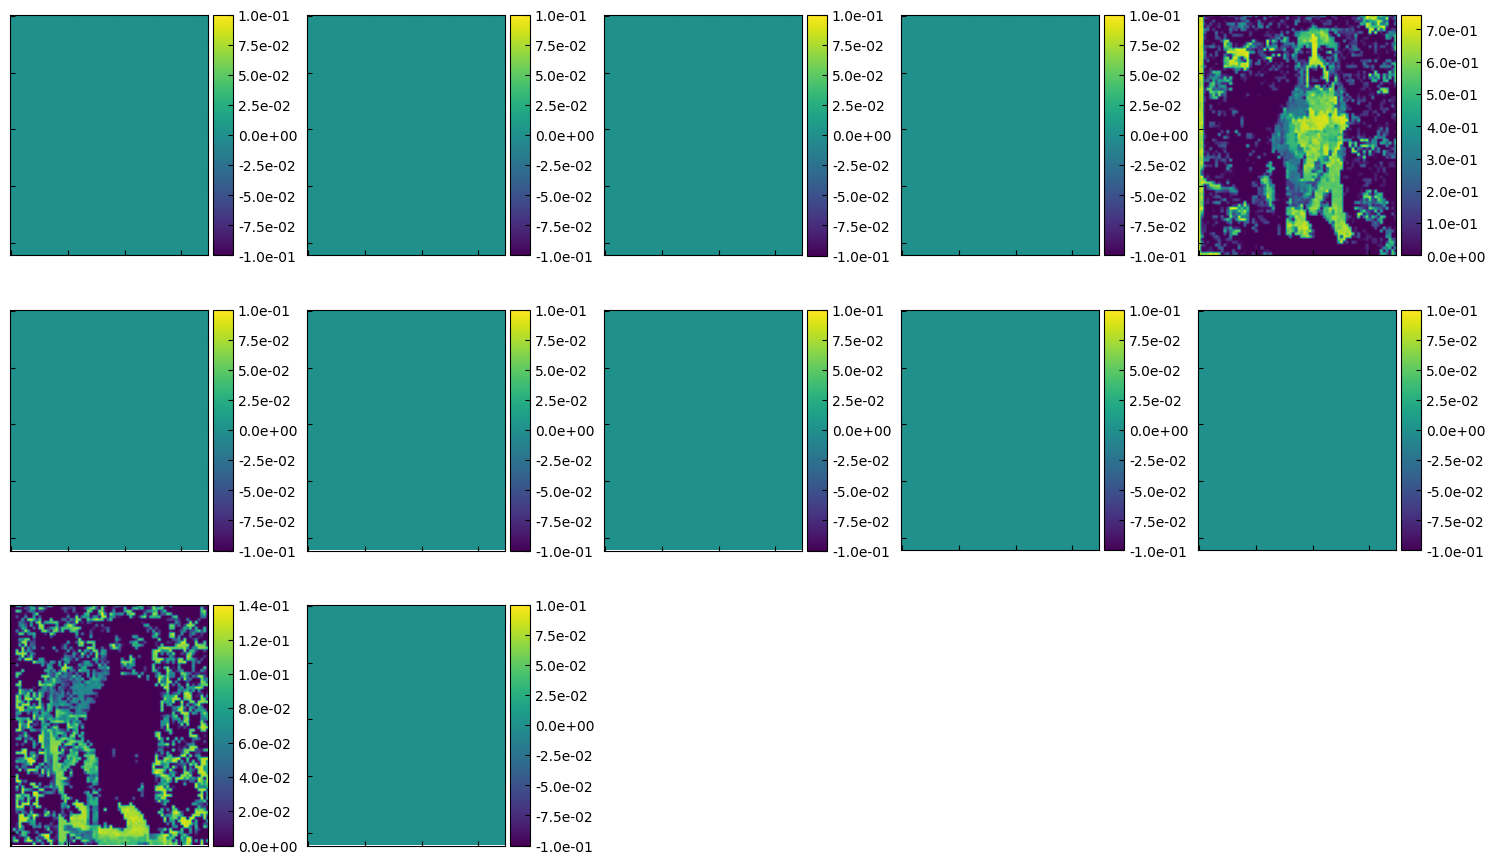

In [42]:
embedding_maps(encode, image)


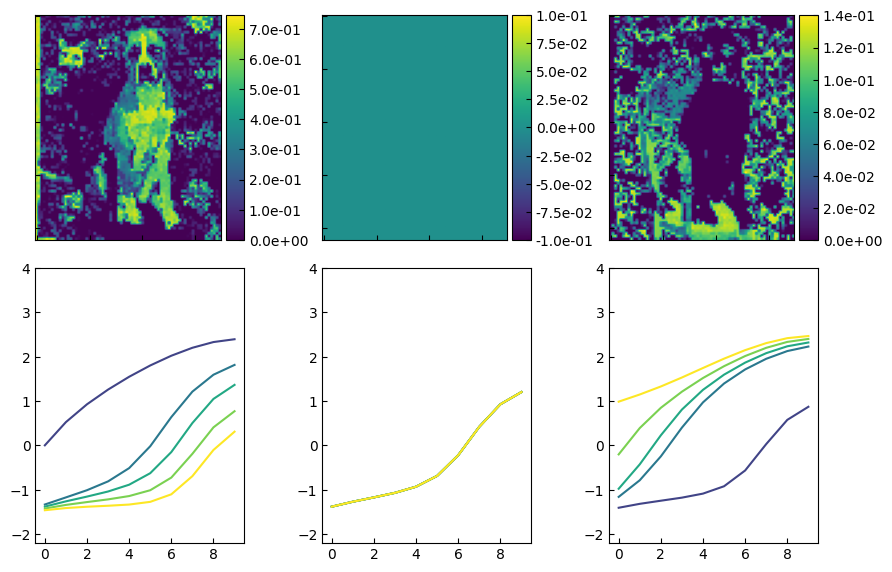

In [43]:
latent_generator(decoder, encode, image, 5, 10, indx=[4, 3, 10], device=device)


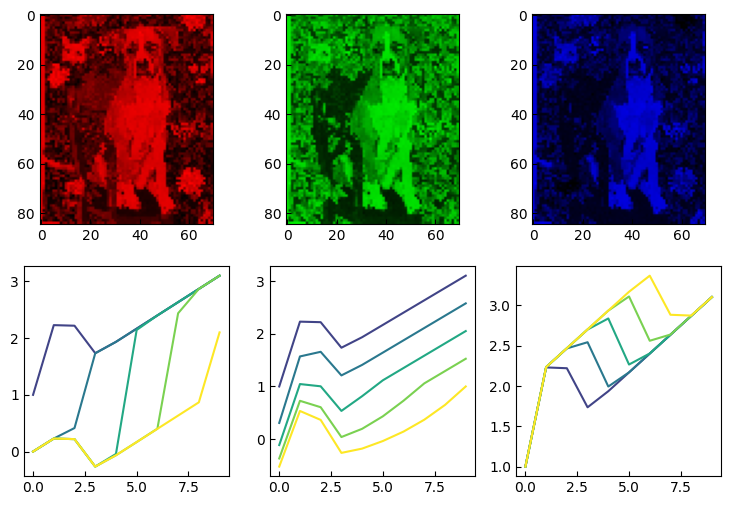

In [44]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [45]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


C:\Conda\envs\m3_learning\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Beta Variational Autoencoder
* Constrict and sample the latent space from some prior distribution --> generally a gaussian distribution

# Normal Autoencoder
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE1.png?raw=true)

# VAE
* Encoder identifies some distribution --> generates from that distribution
![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE2.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE3.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/VAE4.png?raw=true)

In [46]:
latent_dim = 12

# input (batch,)
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        #     x = x.transpose(1,2)

        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [47]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [48]:
def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device = device
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:

            beta = 0
        else:

            beta = ((epoch - initial_epochs) // epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if (
            (epoch - initial_epochs) // epoch_per_beta
            == (epoch - initial_epochs) / epoch_per_beta
        ) and (epoch >= initial_epochs):

            best_train_loss = float("inf")

        if best_train_loss > train_loss:
            best_train_loss = train_loss
            patience_counter = 1
            checkpoint = {
                "net": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "encoder": encoder.state_dict(),
                "decoder": decoder.state_dict(),
            }
            if epoch >= 0:
                torch.save(
                    checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                )


In [49]:
torch.manual_seed(0)
Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device = device,
)


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.77it/s]

Epoch 0, Train Loss: 2.1055
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.75it/s]

Epoch 1, Train Loss: 2.0683
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.82it/s]

Epoch 2, Train Loss: 2.0328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.69it/s]

Epoch 3, Train Loss: 2.0028
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.61it/s]

Epoch 4, Train Loss: 1.9607
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.61it/s]

Epoch 5, Train Loss: 1.9102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 6, Train Loss: 1.8534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.07it/s]

Epoch 7, Train Loss: 1.7744
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.83it/s]

Epoch 8, Train Loss: 1.6892
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 9, Train Loss: 1.5761
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.72it/s]

Epoch 10, Train Loss: 1.4694
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.50it/s]

Epoch 11, Train Loss: 1.3667
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.61it/s]

Epoch 12, Train Loss: 1.2435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.49it/s]

Epoch 13, Train Loss: 1.1345
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.20it/s]

Epoch 14, Train Loss: 1.0432
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.83it/s]

Epoch 15, Train Loss: 0.9562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.56it/s]

Epoch 16, Train Loss: 0.8767
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.51it/s]

Epoch 17, Train Loss: 0.7903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.36it/s]

Epoch 18, Train Loss: 0.7102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.59it/s]

Epoch 19, Train Loss: 0.6191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.04it/s]

Epoch 20, Train Loss: 0.5343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.40it/s]

Epoch 21, Train Loss: 0.4568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.55it/s]

Epoch 22, Train Loss: 0.3811
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.59it/s]

Epoch 23, Train Loss: 0.3270
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.38it/s]

Epoch 24, Train Loss: 0.2903
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.02it/s]

Epoch 25, Train Loss: 0.2677
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.51it/s]

Epoch 26, Train Loss: 0.2524
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.69it/s]

Epoch 27, Train Loss: 0.2430
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 28, Train Loss: 0.2323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.41it/s]

Epoch 29, Train Loss: 0.2246
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.48it/s]

Epoch 30, Train Loss: 0.2180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.58it/s]

Epoch 31, Train Loss: 0.2118
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 32, Train Loss: 0.2067
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 33, Train Loss: 0.2031
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.65it/s]

Epoch 34, Train Loss: 0.1971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.53it/s]

Epoch 35, Train Loss: 0.1941
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.88it/s]

Epoch 36, Train Loss: 0.1889
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.18it/s]

Epoch 37, Train Loss: 0.1866
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.56it/s]

Epoch 38, Train Loss: 0.1833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.52it/s]

Epoch 39, Train Loss: 0.1795
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.52it/s]

Epoch 40, Train Loss: 0.1766
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.98it/s]

Epoch 41, Train Loss: 0.1738
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.20it/s]

Epoch 42, Train Loss: 0.1705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.49it/s]

Epoch 43, Train Loss: 0.1680
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 44, Train Loss: 0.1656
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.61it/s]

Epoch 45, Train Loss: 0.1624
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 46, Train Loss: 0.1593
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.43it/s]

Epoch 47, Train Loss: 0.1566
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 48, Train Loss: 0.1541
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.48it/s]

Epoch 49, Train Loss: 0.1515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.49it/s]

Epoch 50, Train Loss: 0.1484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.54it/s]

Epoch 51, Train Loss: 0.1460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 52, Train Loss: 0.1429
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.12it/s]

Epoch 53, Train Loss: 0.1398
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.48it/s]

Epoch 54, Train Loss: 0.1376
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.36it/s]

Epoch 55, Train Loss: 0.1351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.43it/s]

Epoch 56, Train Loss: 0.1326
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.24it/s]

Epoch 57, Train Loss: 0.1308
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.48it/s]

Epoch 58, Train Loss: 0.1287
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.18it/s]

Epoch 59, Train Loss: 0.1266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.81it/s]

Epoch 60, Train Loss: 0.1249
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.56it/s]

Epoch 61, Train Loss: 0.1231
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.38it/s]

Epoch 62, Train Loss: 0.1217
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 63, Train Loss: 0.1203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.95it/s]

Epoch 64, Train Loss: 0.1186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.53it/s]

Epoch 65, Train Loss: 0.1173
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.52it/s]

Epoch 66, Train Loss: 0.1163
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 67, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.60it/s]

Epoch 68, Train Loss: 0.1138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.46it/s]

Epoch 69, Train Loss: 0.1127
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 70, Train Loss: 0.1114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.80it/s]

Epoch 71, Train Loss: 0.1105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 72, Train Loss: 0.1092
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.02it/s]

Epoch 73, Train Loss: 0.1082
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.56it/s]

Epoch 74, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.91it/s]

Epoch 75, Train Loss: 0.1060
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.56it/s]

Epoch 76, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.98it/s]

Epoch 77, Train Loss: 0.1034
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.15it/s]

Epoch 78, Train Loss: 0.1022
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.46it/s]

Epoch 79, Train Loss: 0.1009
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.57it/s]

Epoch 80, Train Loss: 0.0994
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.17it/s]

Epoch 81, Train Loss: 0.0980
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.00it/s]

Epoch 82, Train Loss: 0.0965
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.56it/s]

Epoch 83, Train Loss: 0.0946
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.57it/s]

Epoch 84, Train Loss: 0.0928
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 85, Train Loss: 0.0908
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.41it/s]

Epoch 86, Train Loss: 0.0888
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.39it/s]

Epoch 87, Train Loss: 0.0865
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.37it/s]

Epoch 88, Train Loss: 0.0845
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 89, Train Loss: 0.0821
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.40it/s]

Epoch 90, Train Loss: 0.0797
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.36it/s]

Epoch 91, Train Loss: 0.0771
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.80it/s]

Epoch 92, Train Loss: 0.0751
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.02it/s]

Epoch 93, Train Loss: 0.0733
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.40it/s]

Epoch 94, Train Loss: 0.0718
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.70it/s]

Epoch 95, Train Loss: 0.0705
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.85it/s]

Epoch 96, Train Loss: 0.0693
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.84it/s]

Epoch 97, Train Loss: 0.0684
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.47it/s]

Epoch 98, Train Loss: 0.0672
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.69it/s]

Epoch 99, Train Loss: 0.0662
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.42it/s]

Epoch 100, Train Loss: 0.0652
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.48it/s]

Epoch 101, Train Loss: 0.0643
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.60it/s]

Epoch 102, Train Loss: 0.0634
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.61it/s]

Epoch 103, Train Loss: 0.0625
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.40it/s]

Epoch 104, Train Loss: 0.0616
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 105, Train Loss: 0.0609
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.69it/s]

Epoch 106, Train Loss: 0.0601
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.93it/s]

Epoch 107, Train Loss: 0.0592
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.15it/s]

Epoch 108, Train Loss: 0.0585
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 109, Train Loss: 0.0577
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 204.31it/s]

Epoch 110, Train Loss: 0.0568
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.61it/s]

Epoch 111, Train Loss: 0.0562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.66it/s]

Epoch 112, Train Loss: 0.0556
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.95it/s]

Epoch 113, Train Loss: 0.0549
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.44it/s]

Epoch 114, Train Loss: 0.0542
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.73it/s]

Epoch 115, Train Loss: 0.0534
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.45it/s]

Epoch 116, Train Loss: 0.0528
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.06it/s]

Epoch 117, Train Loss: 0.0521
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.14it/s]

Epoch 118, Train Loss: 0.0515
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 214.46it/s]

Epoch 119, Train Loss: 0.0509
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.71it/s]

Epoch 120, Train Loss: 0.0502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 177.90it/s]

100%|██████████| 19/19 [00:00<00:00, 177.29it/s]

Epoch 121, Train Loss: 0.0497
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.61it/s]

Epoch 122, Train Loss: 0.0490
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 123, Train Loss: 0.0484
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.20it/s]

Epoch 124, Train Loss: 0.0478
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.45it/s]

Epoch 125, Train Loss: 0.0472
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.43it/s]

Epoch 126, Train Loss: 0.0467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.97it/s]

Epoch 127, Train Loss: 0.0460
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.42it/s]

Epoch 128, Train Loss: 0.0456
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.44it/s]

Epoch 129, Train Loss: 0.0449
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.99it/s]

Epoch 130, Train Loss: 0.0444
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.08it/s]

Epoch 131, Train Loss: 0.0439
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.53it/s]

Epoch 132, Train Loss: 0.0433
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.56it/s]

Epoch 133, Train Loss: 0.0427
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.11it/s]

Epoch 134, Train Loss: 0.0422
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.78it/s]

Epoch 135, Train Loss: 0.0416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.35it/s]

Epoch 136, Train Loss: 0.0411
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.62it/s]

Epoch 137, Train Loss: 0.0406
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 244.38it/s]

Epoch 138, Train Loss: 0.0402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 196.13it/s]

Epoch 139, Train Loss: 0.0396
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.49it/s]

Epoch 140, Train Loss: 0.0391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.29it/s]

Epoch 141, Train Loss: 0.0386
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.62it/s]

Epoch 142, Train Loss: 0.0381
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.07it/s]

Epoch 143, Train Loss: 0.0375
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 144, Train Loss: 0.0370
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.91it/s]

Epoch 145, Train Loss: 0.0365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.51it/s]

Epoch 146, Train Loss: 0.0360
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.65it/s]

Epoch 147, Train Loss: 0.0356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.79it/s]

Epoch 148, Train Loss: 0.0351
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.82it/s]

Epoch 149, Train Loss: 0.0347
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 204.29it/s]

Epoch 150, Train Loss: 0.0341
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.92it/s]

Epoch 151, Train Loss: 0.0338
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.99it/s]

Epoch 152, Train Loss: 0.0333
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.86it/s]

Epoch 153, Train Loss: 0.0328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.19it/s]

Epoch 154, Train Loss: 0.0324
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.39it/s]

Epoch 155, Train Loss: 0.0321
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.99it/s]

Epoch 156, Train Loss: 0.0316
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.41it/s]

Epoch 157, Train Loss: 0.0312
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.48it/s]

Epoch 158, Train Loss: 0.0309
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.88it/s]

Epoch 159, Train Loss: 0.0304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.86it/s]

Epoch 160, Train Loss: 0.0301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 211.17it/s]

Epoch 161, Train Loss: 0.0297
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.73it/s]

Epoch 162, Train Loss: 0.0293
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.59it/s]

Epoch 163, Train Loss: 0.0289
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.91it/s]

Epoch 164, Train Loss: 0.0285
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.12it/s]

Epoch 165, Train Loss: 0.0282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.00it/s]

Epoch 166, Train Loss: 0.0279
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 167, Train Loss: 0.0274
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 168, Train Loss: 0.0271
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 169, Train Loss: 0.0267
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 170, Train Loss: 0.0264
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.82it/s]

Epoch 171, Train Loss: 0.0260
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 172, Train Loss: 0.0255
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.47it/s]

Epoch 173, Train Loss: 0.0252
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.38it/s]

Epoch 174, Train Loss: 0.0248
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.86it/s]

Epoch 175, Train Loss: 0.0244
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.88it/s]

Epoch 176, Train Loss: 0.0240
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 95%|█████████▍| 18/19 [00:00<00:00, 176.46it/s]

100%|██████████| 19/19 [00:00<00:00, 175.92it/s]

Epoch 177, Train Loss: 0.0236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.21it/s]

Epoch 178, Train Loss: 0.0232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 211.10it/s]

Epoch 179, Train Loss: 0.0229
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 208.68it/s]

Epoch 180, Train Loss: 0.0225
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.41it/s]

Epoch 181, Train Loss: 0.0222
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 182, Train Loss: 0.0218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.27it/s]

Epoch 183, Train Loss: 0.0215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.83it/s]

Epoch 184, Train Loss: 0.0212
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.40it/s]

Epoch 185, Train Loss: 0.0209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 208.68it/s]

Epoch 186, Train Loss: 0.0206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.73it/s]

Epoch 187, Train Loss: 0.0203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.20it/s]

Epoch 188, Train Loss: 0.0200
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.86it/s]

Epoch 189, Train Loss: 0.0198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.45it/s]

Epoch 190, Train Loss: 0.0196
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.18it/s]

Epoch 191, Train Loss: 0.0193
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.43it/s]

Epoch 192, Train Loss: 0.0191
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 197.87it/s]

Epoch 193, Train Loss: 0.0188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.16it/s]

Epoch 194, Train Loss: 0.0186
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.36it/s]

Epoch 195, Train Loss: 0.0184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.42it/s]

Epoch 196, Train Loss: 0.0182
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.10it/s]

Epoch 197, Train Loss: 0.0181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.35it/s]

Epoch 198, Train Loss: 0.0178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.17it/s]

Epoch 199, Train Loss: 0.0176
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.90it/s]

Epoch 200, Train Loss: 1.7312
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.17it/s]

Epoch 201, Train Loss: 0.7937
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.39it/s]

Epoch 202, Train Loss: 0.4535
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.79it/s]

Epoch 203, Train Loss: 0.3403
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 195.95it/s]

Epoch 204, Train Loss: 0.3059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.40it/s]

Epoch 205, Train Loss: 0.2872
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.44it/s]

Epoch 206, Train Loss: 0.2745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.33it/s]

Epoch 207, Train Loss: 0.2681
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.13it/s]

Epoch 208, Train Loss: 0.2558
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.35it/s]

Epoch 209, Train Loss: 0.2516
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.54it/s]

Epoch 210, Train Loss: 0.2445
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.48it/s]

Epoch 211, Train Loss: 0.2385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.51it/s]

Epoch 212, Train Loss: 0.2344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 213, Train Loss: 0.2294
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.78it/s]

Epoch 214, Train Loss: 0.2268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.60it/s]

Epoch 215, Train Loss: 0.2216
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.69it/s]

Epoch 216, Train Loss: 0.2202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.40it/s]

Epoch 217, Train Loss: 0.2155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.90it/s]

Epoch 218, Train Loss: 0.2126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.38it/s]

Epoch 219, Train Loss: 0.2066
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.60it/s]

Epoch 220, Train Loss: 0.2054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 211.17it/s]

Epoch 221, Train Loss: 0.2025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.88it/s]

Epoch 222, Train Loss: 0.1986
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.46it/s]

Epoch 223, Train Loss: 0.1971
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.89it/s]

Epoch 224, Train Loss: 0.1955
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.80it/s]

Epoch 225, Train Loss: 0.1929
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.64it/s]

Epoch 226, Train Loss: 0.1905
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.18it/s]

Epoch 227, Train Loss: 0.1897
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.24it/s]

Epoch 228, Train Loss: 0.1861
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.49it/s]

Epoch 229, Train Loss: 0.1833
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.59it/s]

Epoch 230, Train Loss: 0.1815
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.61it/s]

Epoch 231, Train Loss: 0.1787
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.58it/s]

Epoch 232, Train Loss: 0.1745
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.81it/s]

Epoch 233, Train Loss: 0.1754
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.60it/s]

Epoch 234, Train Loss: 0.1739
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.55it/s]

Epoch 235, Train Loss: 0.1707
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.91it/s]

Epoch 236, Train Loss: 0.1693
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.35it/s]

Epoch 237, Train Loss: 0.1692
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 238, Train Loss: 0.1662
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 239, Train Loss: 0.1655
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.61it/s]

Epoch 240, Train Loss: 0.1639
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 229.01it/s]

Epoch 241, Train Loss: 0.1617
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.78it/s]

Epoch 242, Train Loss: 0.1611
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.37it/s]

Epoch 243, Train Loss: 0.1608
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.62it/s]

Epoch 244, Train Loss: 0.1581
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.45it/s]

Epoch 245, Train Loss: 0.1552
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.92it/s]

Epoch 246, Train Loss: 0.1562
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.76it/s]

Epoch 247, Train Loss: 0.1540
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.41it/s]

Epoch 248, Train Loss: 0.1533
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.66it/s]

Epoch 249, Train Loss: 0.1505
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 53%|█████▎    | 10/19 [00:00<00:00, 97.99it/s]

100%|██████████| 19/19 [00:00<00:00, 132.82it/s]

Epoch 250, Train Loss: 0.1502
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.54it/s]

Epoch 251, Train Loss: 0.1486
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.48it/s]

Epoch 252, Train Loss: 0.1466
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.46it/s]

Epoch 253, Train Loss: 0.1467
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.42it/s]

Epoch 254, Train Loss: 0.1457
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.54it/s]

Epoch 255, Train Loss: 0.1440
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.37it/s]

Epoch 256, Train Loss: 0.1436
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.42it/s]

Epoch 257, Train Loss: 0.1431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.62it/s]

Epoch 258, Train Loss: 0.1402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.48it/s]

Epoch 259, Train Loss: 0.1395
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.97it/s]

Epoch 260, Train Loss: 0.1391
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.55it/s]

Epoch 261, Train Loss: 0.1372
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.28it/s]

Epoch 262, Train Loss: 0.1368
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.67it/s]

Epoch 263, Train Loss: 0.1363
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.60it/s]

Epoch 264, Train Loss: 0.1350
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.45it/s]

Epoch 265, Train Loss: 0.1331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.55it/s]

Epoch 266, Train Loss: 0.1328
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.59it/s]

Epoch 267, Train Loss: 0.1319
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.57it/s]

Epoch 268, Train Loss: 0.1307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.42it/s]

Epoch 269, Train Loss: 0.1307
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 270, Train Loss: 0.1295
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.80it/s]

Epoch 271, Train Loss: 0.1282
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.38it/s]

Epoch 272, Train Loss: 0.1276
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.79it/s]

Epoch 273, Train Loss: 0.1257
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.89it/s]

Epoch 274, Train Loss: 0.1268
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.78it/s]

Epoch 275, Train Loss: 0.1247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.57it/s]

Epoch 276, Train Loss: 0.1241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.44it/s]

Epoch 277, Train Loss: 0.1237
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.82it/s]

Epoch 278, Train Loss: 0.1224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.90it/s]

Epoch 279, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.69it/s]

Epoch 280, Train Loss: 0.1206
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.47it/s]

Epoch 281, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.56it/s]

Epoch 282, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 283, Train Loss: 0.1190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.52it/s]

Epoch 284, Train Loss: 0.1181
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.41it/s]

Epoch 285, Train Loss: 0.1170
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 286, Train Loss: 0.1156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.50it/s]

Epoch 287, Train Loss: 0.1156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.70it/s]

Epoch 288, Train Loss: 0.1153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.68it/s]

Epoch 289, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.34it/s]

Epoch 290, Train Loss: 0.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.55it/s]

Epoch 291, Train Loss: 0.1139
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.83it/s]

Epoch 292, Train Loss: 0.1123
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 225.79it/s]

Epoch 293, Train Loss: 0.1105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 225.81it/s]

Epoch 294, Train Loss: 0.1113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.55it/s]

Epoch 295, Train Loss: 0.1106
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.36it/s]

Epoch 296, Train Loss: 0.1099
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.24it/s]

Epoch 297, Train Loss: 0.1094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 298, Train Loss: 0.1093
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.80it/s]

Epoch 299, Train Loss: 0.1071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.08it/s]

Epoch 300, Train Loss: 0.1513
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.45it/s]

Epoch 301, Train Loss: 0.1451
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.74it/s]

Epoch 302, Train Loss: 0.1435
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.56it/s]

Epoch 303, Train Loss: 0.1431
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.96it/s]

Epoch 304, Train Loss: 0.1414
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 305, Train Loss: 0.1416
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.81it/s]

Epoch 306, Train Loss: 0.1408
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.51it/s]

Epoch 307, Train Loss: 0.1402
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 213.36it/s]

Epoch 308, Train Loss: 0.1383
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 309, Train Loss: 0.1385
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.21it/s]

Epoch 310, Train Loss: 0.1357
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.53it/s]

Epoch 311, Train Loss: 0.1365
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.26it/s]

Epoch 312, Train Loss: 0.1356
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.74it/s]

Epoch 313, Train Loss: 0.1343
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 314, Train Loss: 0.1340
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.89it/s]

Epoch 315, Train Loss: 0.1344
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.49it/s]

Epoch 316, Train Loss: 0.1323
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.89it/s]

Epoch 317, Train Loss: 0.1331
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.07it/s]

Epoch 318, Train Loss: 0.1322
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.18it/s]

Epoch 319, Train Loss: 0.1327
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.96it/s]

Epoch 320, Train Loss: 0.1301
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.93it/s]

Epoch 321, Train Loss: 0.1298
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.38it/s]

Epoch 322, Train Loss: 0.1304
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.24it/s]

Epoch 323, Train Loss: 0.1266
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.50it/s]

Epoch 324, Train Loss: 0.1278
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.56it/s]

Epoch 325, Train Loss: 0.1284
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.58it/s]

Epoch 326, Train Loss: 0.1261
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.44it/s]

Epoch 327, Train Loss: 0.1277
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.54it/s]

Epoch 328, Train Loss: 0.1251
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.22it/s]

Epoch 329, Train Loss: 0.1247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.21it/s]

Epoch 330, Train Loss: 0.1247
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.08it/s]

Epoch 331, Train Loss: 0.1243
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.22it/s]

Epoch 332, Train Loss: 0.1232
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.52it/s]

Epoch 333, Train Loss: 0.1226
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.63it/s]

Epoch 334, Train Loss: 0.1236
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 241.83it/s]

Epoch 335, Train Loss: 0.1221
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.39it/s]

Epoch 336, Train Loss: 0.1210
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 191.96it/s]

Epoch 337, Train Loss: 0.1227
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.35it/s]

Epoch 338, Train Loss: 0.1215
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 339, Train Loss: 0.1197
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.42it/s]

Epoch 340, Train Loss: 0.1188
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.37it/s]

Epoch 341, Train Loss: 0.1198
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.55it/s]

Epoch 342, Train Loss: 0.1190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.43it/s]

Epoch 343, Train Loss: 0.1190
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.52it/s]

Epoch 344, Train Loss: 0.1168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.21it/s]

Epoch 345, Train Loss: 0.1168
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.50it/s]

Epoch 346, Train Loss: 0.1179
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.58it/s]

Epoch 347, Train Loss: 0.1175
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.36it/s]

Epoch 348, Train Loss: 0.1155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 211.10it/s]

Epoch 349, Train Loss: 0.1158
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.94it/s]

Epoch 350, Train Loss: 0.1153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.80it/s]

Epoch 351, Train Loss: 0.1151
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.17it/s]

Epoch 352, Train Loss: 0.1153
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 221.03it/s]

Epoch 353, Train Loss: 0.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 236.49it/s]

Epoch 354, Train Loss: 0.1145
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 355, Train Loss: 0.1131
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 356, Train Loss: 0.1133
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.50it/s]

Epoch 357, Train Loss: 0.1134
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 358, Train Loss: 0.1123
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 359, Train Loss: 0.1126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 360, Train Loss: 0.1110
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 361, Train Loss: 0.1114
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 362, Train Loss: 0.1111
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 363, Train Loss: 0.1096
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 364, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 365, Train Loss: 0.1100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 206.52it/s]

Epoch 366, Train Loss: 0.1102
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.39it/s]

Epoch 367, Train Loss: 0.1107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 368, Train Loss: 0.1101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.50it/s]

Epoch 369, Train Loss: 0.1097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.50it/s]

Epoch 370, Train Loss: 0.1083
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 371, Train Loss: 0.1081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 372, Train Loss: 0.1079
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 373, Train Loss: 0.1088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 374, Train Loss: 0.1068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 375, Train Loss: 0.1069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 376, Train Loss: 0.1069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 377, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

 89%|████████▉ | 17/19 [00:00<00:00, 168.32it/s]

100%|██████████| 19/19 [00:00<00:00, 172.73it/s]

Epoch 378, Train Loss: 0.1059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 379, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 380, Train Loss: 0.1056
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 381, Train Loss: 0.1056
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.45it/s]

Epoch 382, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 383, Train Loss: 0.1048
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 384, Train Loss: 0.1039
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 385, Train Loss: 0.1045
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 386, Train Loss: 0.1030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 387, Train Loss: 0.1035
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 388, Train Loss: 0.1032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 389, Train Loss: 0.1038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.50it/s]

Epoch 390, Train Loss: 0.1024
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 391, Train Loss: 0.1020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 392, Train Loss: 0.1020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 393, Train Loss: 0.1023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 394, Train Loss: 0.1014
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 204.30it/s]

Epoch 395, Train Loss: 0.1016
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 396, Train Loss: 0.1007
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.91it/s]

Epoch 397, Train Loss: 0.1006
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 398, Train Loss: 0.1012
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 399, Train Loss: 0.1001
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 400, Train Loss: 0.1241
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 401, Train Loss: 0.1228
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 402, Train Loss: 0.1218
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 403, Train Loss: 0.1202
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 404, Train Loss: 0.1213
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 405, Train Loss: 0.1224
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.00it/s]

Epoch 406, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 407, Train Loss: 0.1203
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.88it/s]

Epoch 408, Train Loss: 0.1195
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 409, Train Loss: 0.1209
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.91it/s]

Epoch 410, Train Loss: 0.1185
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 219.81it/s]

Epoch 411, Train Loss: 0.1184
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 412, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.75it/s]

Epoch 413, Train Loss: 0.1180
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 414, Train Loss: 0.1169
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 415, Train Loss: 0.1167
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 416, Train Loss: 0.1178
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 417, Train Loss: 0.1172
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 222.75it/s]

Epoch 418, Train Loss: 0.1155
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 419, Train Loss: 0.1183
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 420, Train Loss: 0.1159
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 421, Train Loss: 0.1156
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 422, Train Loss: 0.1162
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 423, Train Loss: 0.1147
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 200.00it/s]

Epoch 424, Train Loss: 0.1161
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 425, Train Loss: 0.1141
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.75it/s]

Epoch 426, Train Loss: 0.1143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 427, Train Loss: 0.1137
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 428, Train Loss: 0.1148
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 429, Train Loss: 0.1138
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 430, Train Loss: 0.1144
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 431, Train Loss: 0.1143
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 432, Train Loss: 0.1145
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 433, Train Loss: 0.1126
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 434, Train Loss: 0.1124
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 435, Train Loss: 0.1129
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 215.91it/s]

Epoch 436, Train Loss: 0.1117
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 437, Train Loss: 0.1135
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 438, Train Loss: 0.1116
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 439, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 440, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.76it/s]

Epoch 441, Train Loss: 0.1113
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 442, Train Loss: 0.1101
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 443, Train Loss: 0.1094
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 444, Train Loss: 0.1109
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 445, Train Loss: 0.1104
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.45it/s]

Epoch 446, Train Loss: 0.1091
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 447, Train Loss: 0.1107
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 448, Train Loss: 0.1097
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 449, Train Loss: 0.1100
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 450, Train Loss: 0.1090
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 451, Train Loss: 0.1098
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 452, Train Loss: 0.1105
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 453, Train Loss: 0.1077
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 193.86it/s]

Epoch 454, Train Loss: 0.1085
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 455, Train Loss: 0.1081
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 456, Train Loss: 0.1087
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.75it/s]

Epoch 457, Train Loss: 0.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 458, Train Loss: 0.1088
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 240.51it/s]

Epoch 459, Train Loss: 0.1075
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.44it/s]

Epoch 460, Train Loss: 0.1069
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 461, Train Loss: 0.1074
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.91it/s]

Epoch 462, Train Loss: 0.1068
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 463, Train Loss: 0.1071
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 464, Train Loss: 0.1079
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 465, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 202.08it/s]

Epoch 466, Train Loss: 0.1059
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 467, Train Loss: 0.1052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 468, Train Loss: 0.1058
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.39it/s]

Epoch 469, Train Loss: 0.1054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 470, Train Loss: 0.1070
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 246.75it/s]

Epoch 471, Train Loss: 0.1053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 472, Train Loss: 0.1063
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 473, Train Loss: 0.1053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 474, Train Loss: 0.1051
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 475, Train Loss: 0.1052
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 476, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 477, Train Loss: 0.1054
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 478, Train Loss: 0.1049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 479, Train Loss: 0.1032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 480, Train Loss: 0.1053
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 481, Train Loss: 0.1047
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 482, Train Loss: 0.1049
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 201.38it/s]

Epoch 483, Train Loss: 0.1043
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 484, Train Loss: 0.1033
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 223.53it/s]

Epoch 485, Train Loss: 0.1038
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 486, Train Loss: 0.1040
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 231.71it/s]

Epoch 487, Train Loss: 0.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 488, Train Loss: 0.1037
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 228.92it/s]

Epoch 489, Train Loss: 0.1032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 237.50it/s]

Epoch 490, Train Loss: 0.1032
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 234.57it/s]

Epoch 491, Train Loss: 0.1030
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 492, Train Loss: 0.1023
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 243.59it/s]

Epoch 493, Train Loss: 0.1025
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 226.19it/s]

Epoch 494, Train Loss: 0.1027
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 190.00it/s]

Epoch 495, Train Loss: 0.1020
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 218.39it/s]

Epoch 496, Train Loss: 0.1010
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 211.11it/s]

Epoch 497, Train Loss: 0.1011
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 498, Train Loss: 0.1015
.............................


  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 499, Train Loss: 0.1017
.............................


In [50]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [51]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()

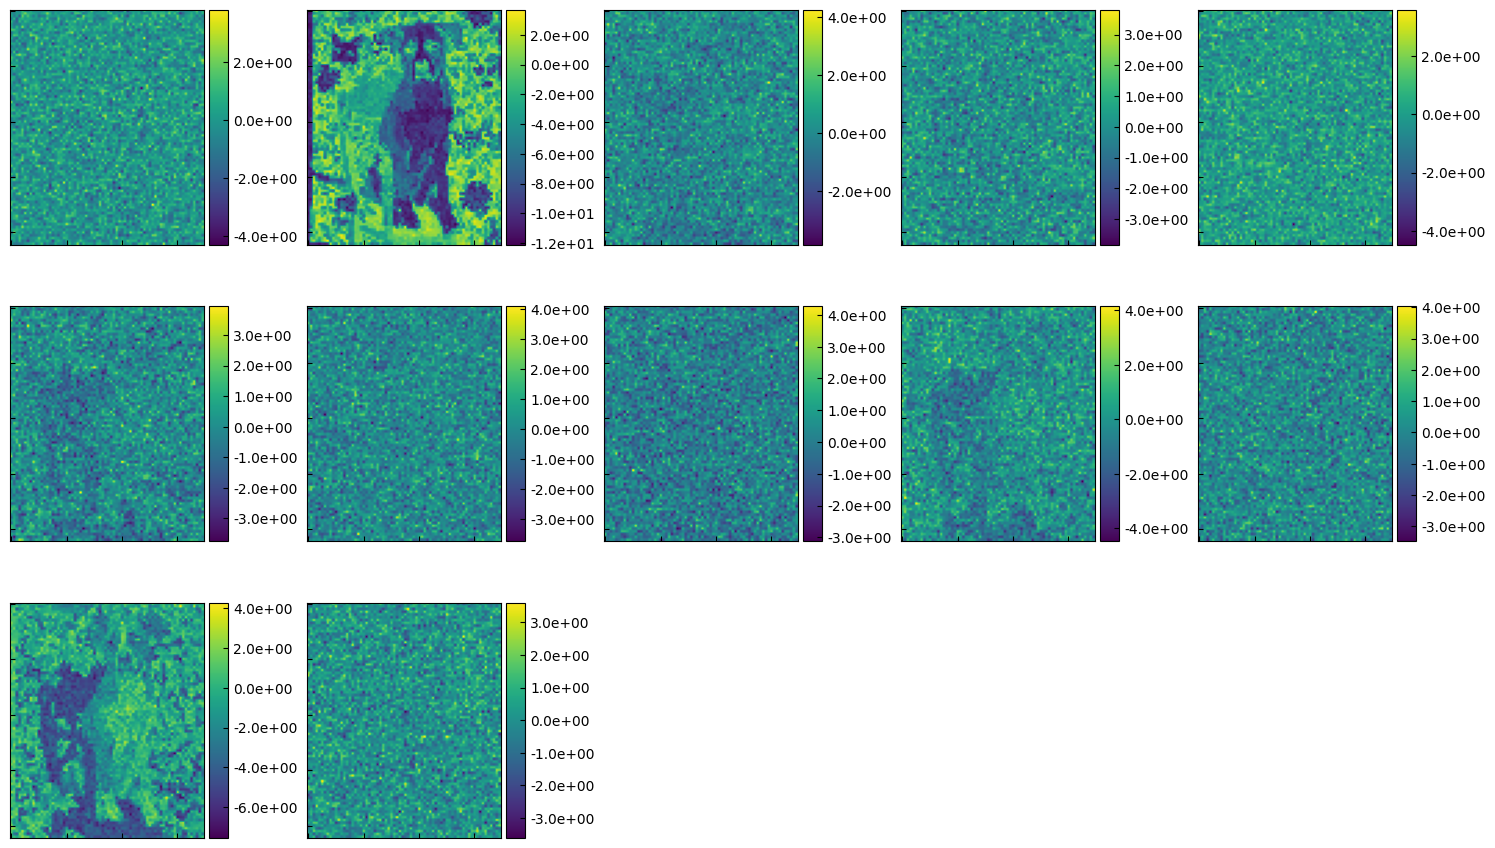

In [52]:
embedding_maps(encoded_spectra, image)


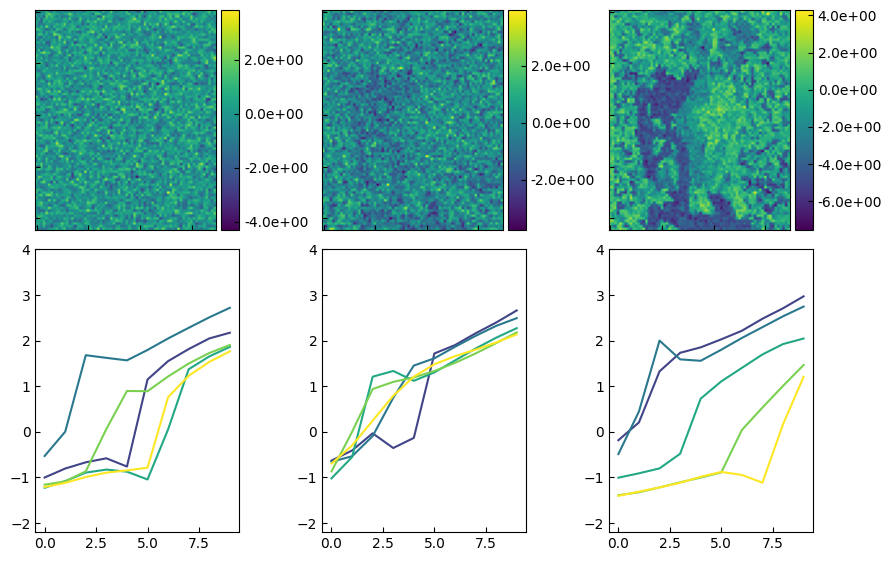

In [53]:
latent_generator(decoder, encoded_spectra, image, 5, 10, indx=[0, 5, 10], device = device)


* disentanglement with $\beta$ VAE requires careful control of optimiztion. 